# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

Autopistas Urbanas (AUSA). Secretaría de Transporte y Obras Públicas. Jefatura de Gabinete de Ministros

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

## 1. Preparación del Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
sns.set()

import datetime

import warnings
warnings.filterwarnings('ignore')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
print("Rango para los enteros: ")
print(np.iinfo(int), np.iinfo(np.int8), np.iinfo(np.int16), np.iinfo(np.int32))

Rango para los enteros: 
Machine parameters for int64
---------------------------------------------------------------
min = -9223372036854775808
max = 9223372036854775807
---------------------------------------------------------------
 Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------
 Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------
 Machine parameters for int32
---------------------------------------------------------------
min = -2147483648
max = 2147483647
---------------------------------------------------------------



**>>** Antes de la lectura de cada archivo, se definen las columnas de interés, su orden y para los enteros su tipo (int16, int32). 

>Incialmente se analizó el DataSet de 2020, tiene más columnas que los de 2016 a 2019 y al leerlo la columna 'cantidad_pasos' queda como float64.

In [3]:
# Columnas de interés, su orden y tipo de dato para los enteros
columns = ['periodo', 'fecha', 'hora_inicio', 'hora_fin', 'dia', 'estacion', 
           'sentido', 'tipo_vehiculo', 'forma_pago', 'cantidad_pasos']

# Tipo de dato entero acorde con el rango de cada variable
col_dtypes= {'periodo': np.int16, 'hora_inicio': np.int8, 'hora_fin': np.int8, 'cantidad_pasos': np.int32}

# Lectura de los archivos
#data_2021 = pd.read_csv('datasets/proyecto3_ST/flujo-vehicular-2021.csv', sep =',')

#data_2020 = pd.read_csv('datasets/proyecto3_ST/flujo-vehicular-2020.csv', sep =',', usecols=columns, dtype=col_dtypes)[columns]
data_2020 = pd.read_csv('datasets/proyecto3_ST/flujo-vehicular-2020.csv', sep =',', usecols=columns)[columns]
data_2020 = data_2020.astype(col_dtypes)

data_2019 = pd.read_csv('datasets/proyecto3_ST/flujo-vehicular-2019.csv', sep =',', usecols=columns)[columns]
data_2019 = data_2019.astype(col_dtypes)

data_2018 = pd.read_csv('datasets/proyecto3_ST/flujo-vehicular-2018.csv', sep =',', usecols=columns)[columns]
data_2018 = data_2018.astype(col_dtypes)

data_2017 = pd.read_csv('datasets/proyecto3_ST/flujo-vehicular-2017.csv', sep =',', usecols=columns)[columns]
data_2017 = data_2017.astype(col_dtypes)

data_2016 = pd.read_csv('datasets/proyecto3_ST/flujo-vehicular-2016.csv', sep =',', usecols=columns)[columns]
data_2016 = data_2016.astype(col_dtypes)

**>>** Adicionalmente, todas las columnas tipo Object se lleva a Minúsculas

>Y la columna fecha se convierte a datetime

In [4]:
for df in [data_2020, data_2019, data_2018, data_2017, data_2016]:
    #df['cantidad_pasos'] = df['cantidad_pasos'].astype(np.int64)   # Se convierte la cantidad de pasos a int32
    df['fecha'] = pd.to_datetime(df['fecha'])
    for col in ['dia', 'estacion', 'sentido', 'tipo_vehiculo', 'forma_pago']:
        df[col] = df[col].str.lower()

**>>** Se valida cada dataset: tienen las mismas columnas y con el mismo tipo de dato?

In [5]:
df_total = [data_2020, data_2019, data_2018, data_2017, data_2016]

for idx in range(len(df_total)):
    if((idx + 1) == (len(df_total) - 1)):
        print("\n\n >>>>>>>>>>>>>>> Todos los dataset tienen las mismas características. Mismas columnas con el mismo tipo y en el mismo orden")
        break
    if(df_total[idx].info(verbose=False) != df_total[idx + 1].info(verbose=False)):
        print("\n\n >>>>>>>>>>>>>>> Los datasets no son consistentes en sus características")
        
del df_total

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533743 entries, 0 to 2533742
Columns: 10 entries, periodo to cantidad_pasos
dtypes: datetime64[ns](1), int16(1), int32(1), int8(2), object(5)
memory usage: 135.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Columns: 10 entries, periodo to cantidad_pasos
dtypes: datetime64[ns](1), int16(1), int32(1), int8(2), object(5)
memory usage: 43.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Columns: 10 entries, periodo to cantidad_pasos
dtypes: datetime64[ns](1), int16(1), int32(1), int8(2), object(5)
memory usage: 43.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Columns: 10 entries, periodo to cantidad_pasos
dtypes: datetime64[ns](1), int16(1), int32(1), int8(2), object(5)
memory usage: 73.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Columns: 10 entries, periodo to cantidad_pasos
dtypes: date

**>>** Se consulta .info() de solo un dataset

In [6]:
data_2020.info()
data_2020.sample(5)
#data_2020.head()
#data_2020.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533743 entries, 0 to 2533742
Data columns (total 10 columns):
 #   Column          Dtype         
---  ------          -----         
 0   periodo         int16         
 1   fecha           datetime64[ns]
 2   hora_inicio     int8          
 3   hora_fin        int8          
 4   dia             object        
 5   estacion        object        
 6   sentido         object        
 7   tipo_vehiculo   object        
 8   forma_pago      object        
 9   cantidad_pasos  int32         
dtypes: datetime64[ns](1), int16(1), int32(1), int8(2), object(5)
memory usage: 135.3+ MB


periodo      fecha  hora_inicio  hora_fin        dia  \
1826221     2020 2020-09-24           12        13     jueves   
2158111     2020 2020-11-18           13        14  miércoles   
1876639     2020 2020-10-14            2         3  miércoles   
2125549     2020 2020-11-23            8         9      lunes   
1794970     2020 2020-09-09           18        19  miércoles   

                                 estacion    sentido   tipo_vehiculo  \
1826221                               ilp     centro  pesados 5 ejes   
2158111  dellepiane linierslepiane centro     centro            moto   
1876639                               pb1  provincia            auto   
2125549                          salguero  provincia            auto   
1794970  dellepiane linierslepiane centro     centro  pesados 4 ejes   

        forma_pago  cantidad_pasos  
1826221        tag              64  
2158111  rec.deuda               2  
1876639        tag               8  
2125549        tag               3  
1794970        tag               2

Investiguemos qué valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [7]:
for col in ['dia', 'estacion', 'sentido', 'tipo_vehiculo', 'forma_pago']:
    print("\nValores para el campo " + str(col))
    for df in [data_2020, data_2019, data_2018, data_2017, data_2016]:
    
        print(str(df['periodo'].iloc[0]) + " >> " + str(df[col].unique()))


Valores para el campo dia
2020 >> ['miércoles' 'jueves' 'viernes' 'sábado' 'domingo' 'lunes' 'martes']
2019 >> ['martes' 'viernes' 'lunes' 'miércoles' 'sábado' 'jueves' 'domingo']
2018 >> ['lunes' 'martes' 'miércoles' 'jueves' 'viernes' 'sábado' 'domingo']
2017 >> ['domingo' 'lunes' 'martes' 'miércoles' 'jueves' 'viernes' 'sábado']
2016 >> ['viernes' 'sábado' 'domingo' 'lunes' 'martes' 'miércoles' 'jueves']

Valores para el campo estacion
2020 >> ['alberdi' 'avellaneda' 'dellepiane linierslepiane centro'
 'dellepiane liniers' 'illia' 'ilp' 'pb1' 'pb3' 'pb4' 'retiro' 'salguero'
 'sarmiento' 'pb2']
2019 >> ['alberti' 'avellaneda' 'dellepiane' 'illia' 'retiro' 'salguero'
 'sarmiento' 'pdb']
2018 >> ['alberdi' 'avellaneda' 'dellepiane centro' 'dellepiane liniers' 'illia'
 'retiro' 'salguero' 'sarmiento']
2017 >> ['alberdi' 'avellaneda' 'dellepiane centro' 'dellepiane liniers' 'illia'
 'retiro' 'salguero' 'sarmiento']
2016 >> ['alberdi' 'avellaneda' 'dellepiane centro' 'dellepiane liniers'

In [8]:
#print(data_2020['estacion'].unique())
#print(data_2019['estacion'].unique())

##### Podemos decir entonces que los años 2016 a 2020 tienen las siguientes columnas con la siguiente información:

>**periodo**: año del dset 

>**fecha**: año mes día

>**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

>**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

>**dia**: dia de la semana 

>**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

>**sentido**: Centro o Provincia

>**tipo_vehiculo**: Liviano o Pesado

>**forma_pago**: Hay varias y varian entre los años.

>**cantidad_pasos**: Cantidad de vehiculos

**>>** Se hace el siguiente procesamiento:

>Para la columna 'forma_pago' de 2020, el valor 'tarjeta magnética' se convierte a 'telepase'.

>Y para la columna 'tipo_vehiculo' del 2020: si el valor contiene la palabra 'pesado' se convierte a 'pesado', sino el valor es 'liviano'

In [9]:
data_2020['forma_pago'] = data_2020['forma_pago'].map(lambda value: 'telepase' if value == 'tarjeta magnética' else value )

In [10]:
data_2020['tipo_vehiculo'] = data_2020['tipo_vehiculo'].map(lambda value: 'pesado' if 'pesado' in value else 'liviano' )

>Se valida que el procesamiento sea correcto

In [11]:
print(data_2020['tipo_vehiculo'].unique())

['liviano' 'pesado']


In [12]:
print(data_2020['forma_pago'].unique())
print(data_2019['forma_pago'].unique())

['efectivo' 'rec.deuda' 'telepase' 'tag' 'exento' 'violación' 'cpp'
 'mercado pago']
['no cobrado' 'telepase' 'efectivo' 'exento' 'infraccion'
 't. discapacidad']


>Generar un dataset con todos los datos

In [13]:
#Unimos los datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas y con las mismas características
dataset = pd.concat([data_2020, data_2019, data_2018, data_2017, data_2016])
#dataset_total = dataset.copy()

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)
#dataset.head()

#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
#dataset.head()

#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
#dataset.head()
print("Tamaño del dataset por hora: " + str(dataset.shape))

#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print("Tamaño del dataset por día: " + str(diario.shape))
#diario.head()

Tamaño del dataset por hora: (7473892, 7)
Tamaño del dataset por día: (1827, 1)


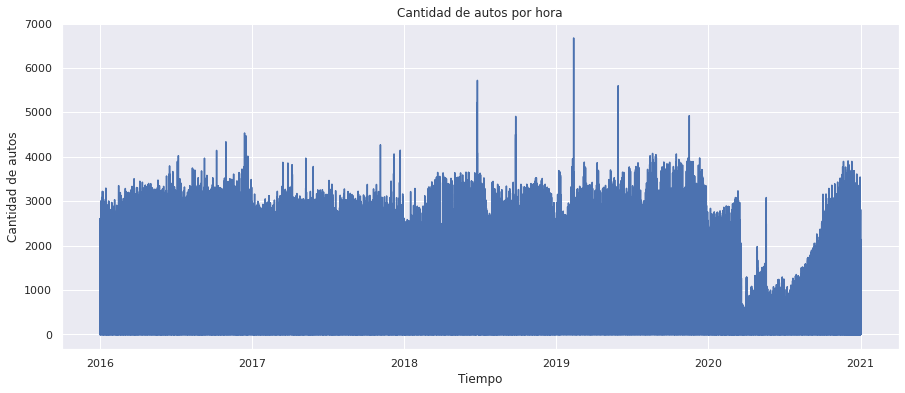

In [14]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.title('Cantidad de autos por hora')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.show()

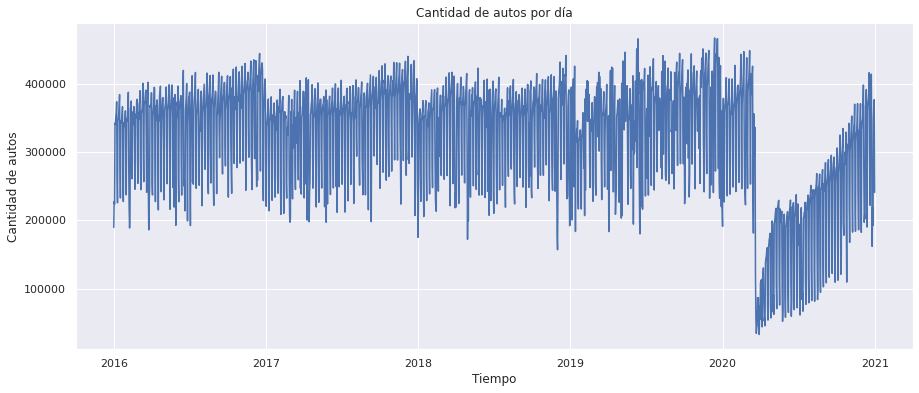

In [15]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.title('Cantidad de autos por día')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.show()

>Hagamos Zoom cerca de marzo de 2020

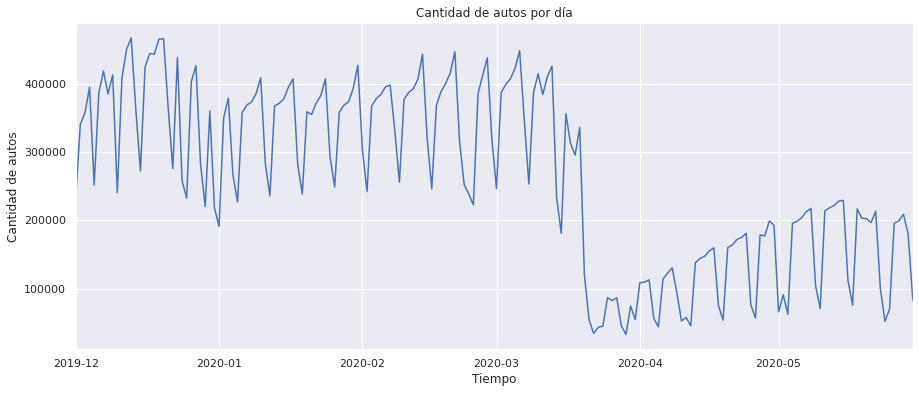

In [16]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.title('Cantidad de autos por día')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.xlim(datetime.date(2019,12,1), datetime.date(2020,5,30))
plt.show()

In [17]:
#plt.figure(figsize = (15,6))
#plt.plot(diario.index, diario.cantidad_pasos)
#plt.title('Cantidad de autos por día')
#plt.xlabel('Tiempo')
#plt.ylabel('Cantidad de autos')
#plt.xlim(datetime.date(2020,3,1), datetime.date(2020,3,31))
#plt.show()

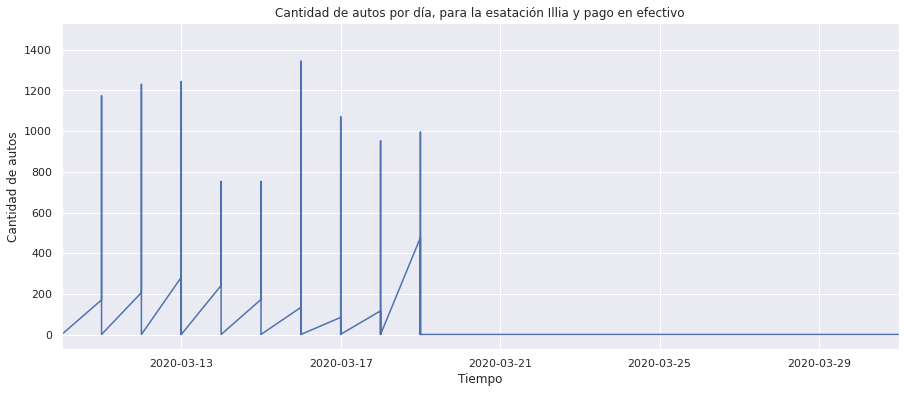

In [18]:
#Graficamos nuestros datos, haciendo Zoom en Marzo de 2020
plt.figure(figsize = (15,6))
plt.plot(data_2020[np.logical_and(data_2020.estacion=='illia', data_2020.forma_pago == 'efectivo')].fecha, 
         data_2020[np.logical_and(data_2020.estacion=='illia', data_2020.forma_pago == 'efectivo')].cantidad_pasos)
plt.title('Cantidad de autos por día, para la esatación Illia y pago en efectivo')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.xlim(datetime.date(2020,3,10), datetime.date(2020,3,31))
plt.show()

*** Por la pandemia del covid-19 ***

> Se hizo un análisis de del año 2020 para la estación Illia, y los datos a partir de Marzo sufren una caída a cero, y nuevamente en Mayo se tienen datos pero por debajo de la tendencia

> Es por ello que para el 2020 solo se toma hasta marzo 19.

##### Se recrea nuevamente el dataset con corte a 19 marzo de 2020

In [19]:
#Unimos los datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas y con las mismas características
dataset = pd.concat([data_2020[(data_2020['fecha'] >= "2020-01-01") & (data_2020['fecha'] <= "2020-03-19")],
                    data_2019, data_2018, data_2017, data_2016])

#dataset_total = dataset.copy()

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)
#dataset.head()

#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
#dataset.head()

#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
#dataset.head()
print("Tamaño del dataset por hora: " + str(dataset.shape))

#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print("Tamaño del dataset por día: " + str(diario.shape))
#diario.head()

Tamaño del dataset por hora: (5573908, 7)
Tamaño del dataset por día: (1540, 1)


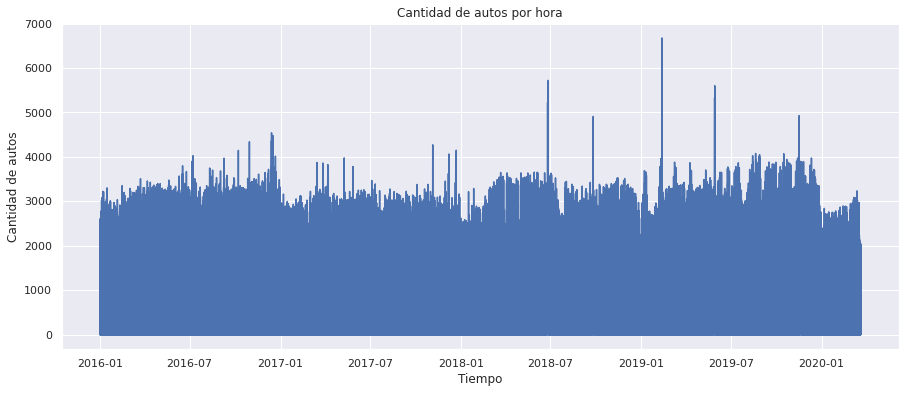

In [20]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.title('Cantidad de autos por hora')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.show()

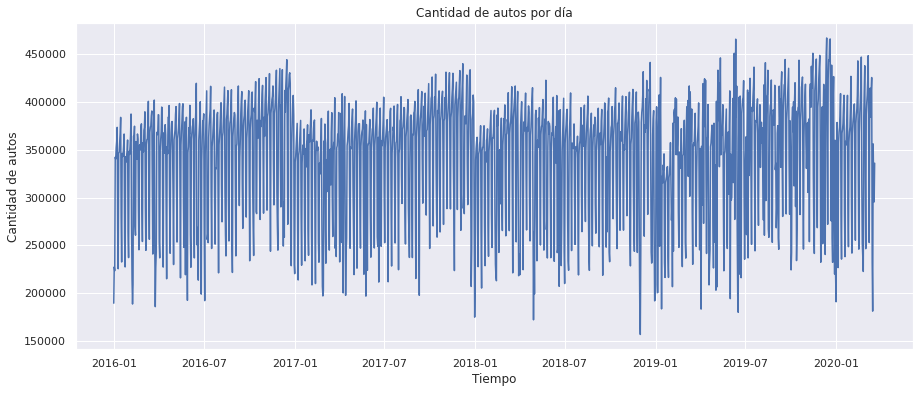

In [21]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.title('Cantidad de autos por día')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.show()

## 2. Exploración de datos

In [22]:
dataset.describe()

cantidad_pasos
count    5.573908e+06
mean     9.463006e+01
std      3.064260e+02
min      1.000000e+00
25%      2.000000e+00
50%      7.000000e+00
75%      2.900000e+01
max      6.677000e+03

En promedio pasan 95 carros por hora en las estaciones

In [23]:
diario.describe()

cantidad_pasos
count     1540.000000
mean    342505.988312
std      62382.419055
min     156852.000000
25%     293764.250000
50%     362376.500000
75%     388098.250000
max     466887.000000

Por su parte, en promedio pasan 340 mil+ carros por día en las estaciones

Hay valores faltantes en el dataset?

In [24]:
dataset.isna().sum()

dia               0
estacion          0
sentido           0
tipo_vehiculo     0
forma_pago        0
cantidad_pasos    0
fecha             0
dtype: int64

>No hay valores faltantes

Se crea una función para graficar los datos agrupados y con funciones de agregación

In [25]:
def graficar_datos(datos, columna_x, columna_y, cols_hue, fun_agregacion):
    """
        datos  >>  DataFrame
        coumna_x  >>  eje x
        columna_y >>  eje y
        cols_hue >> para desagregar los datos en cada gráfica
        fun_agregacion  >> Operación de agregación que se va a calcular sobre la columna
    """
    
    plt.figure(figsize = (18,8))
    plt.title(columna_y + " por " + columna_x)
    sns.barplot(x=columna_x, y=columna_y, data=datos, estimator=fun_agregacion, ci=None)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)
    plt.show()

    for hue in cols_hue:
        plt.figure(figsize = (18,8))
        plt.title(columna_y + " por " + columna_x + ", desagregado por " + hue)
        sns.barplot(x=columna_x, y=columna_y, hue=hue, data=datos, estimator=fun_agregacion, ci=None)
        locs, labels = plt.xticks()
        plt.setp(labels, rotation=45)
        plt.show()

##### Cantidad de Pasos por Estación, desagregado por Sentido, Tipo vehículo, Forma pago y Día

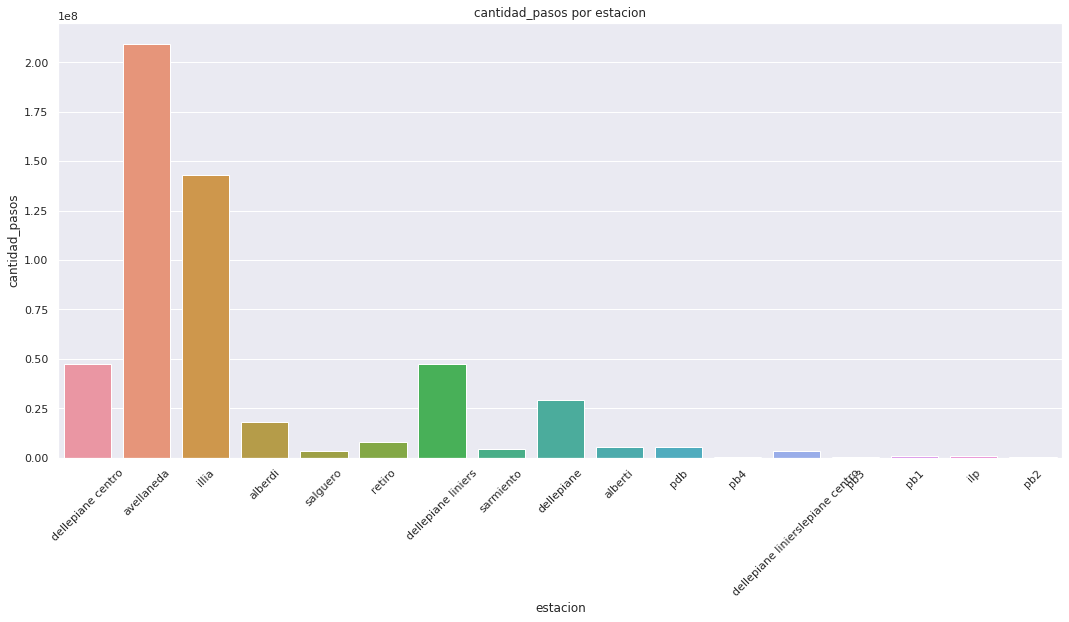

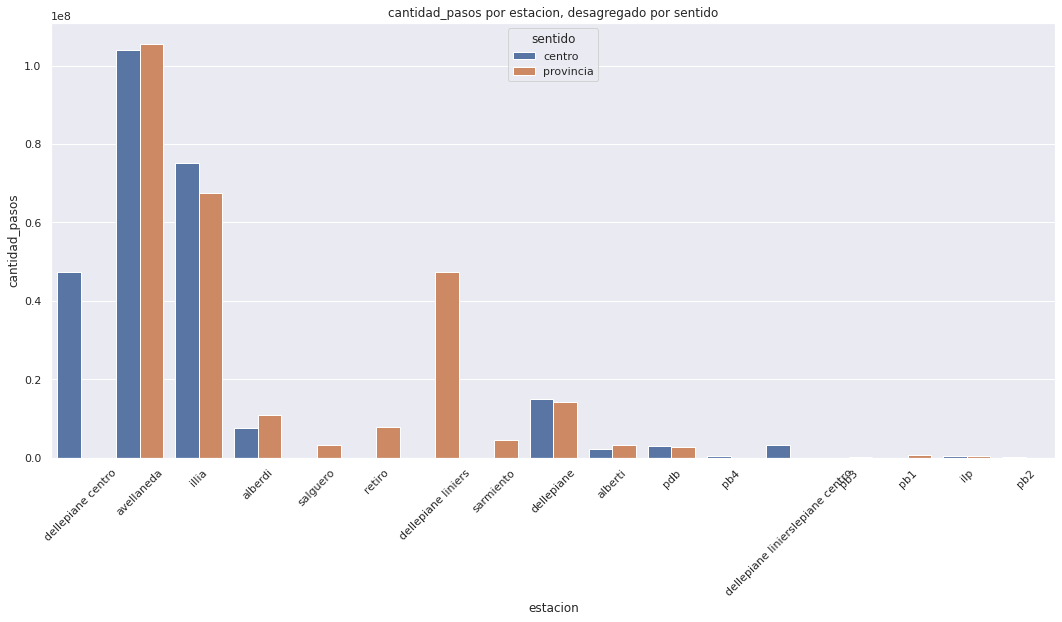

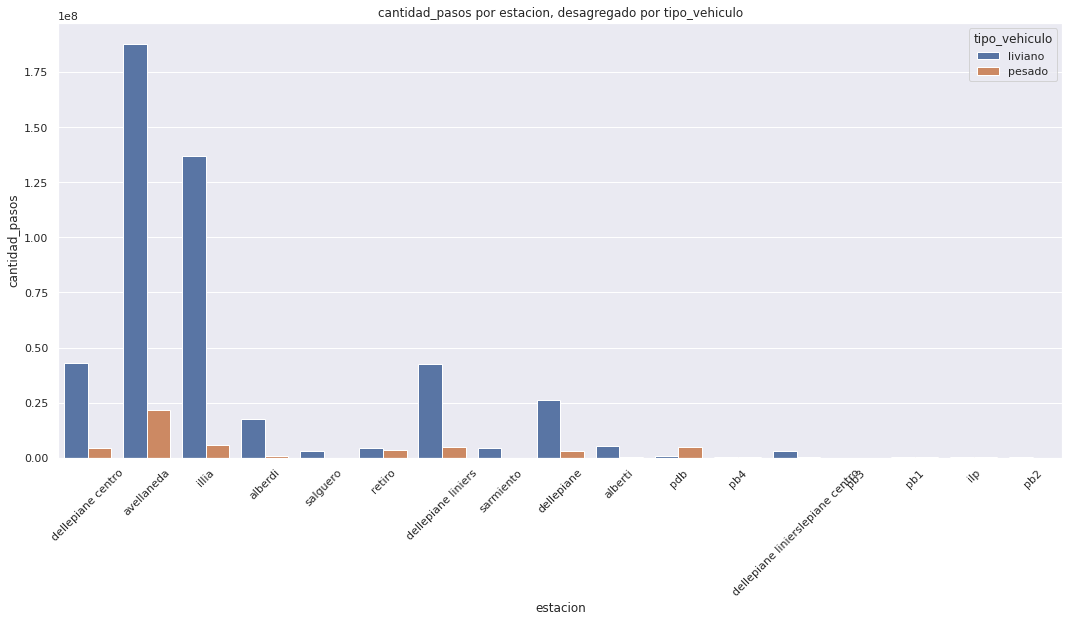

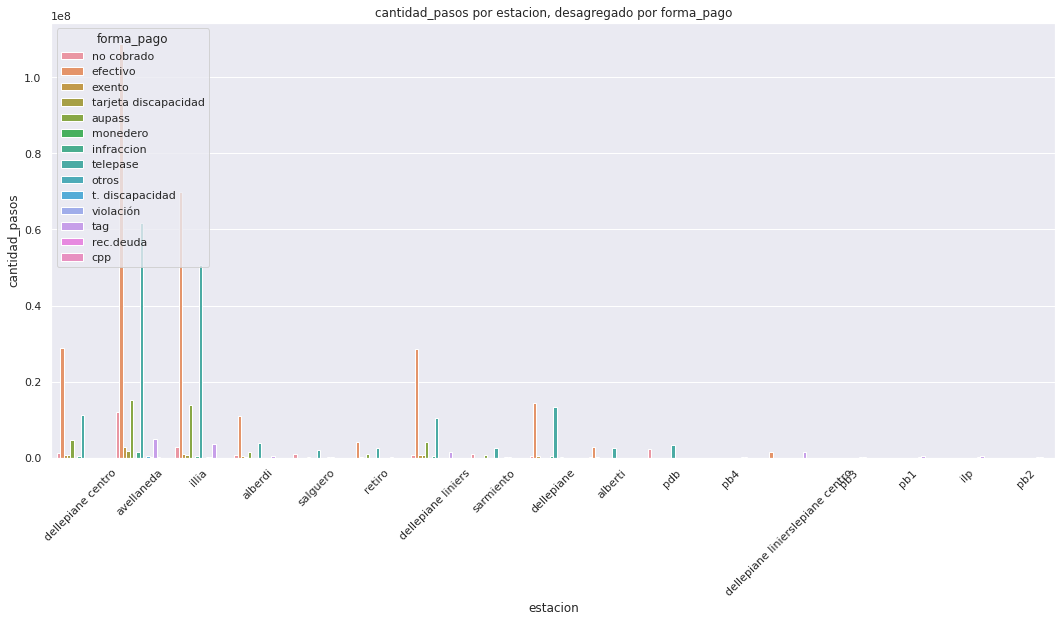

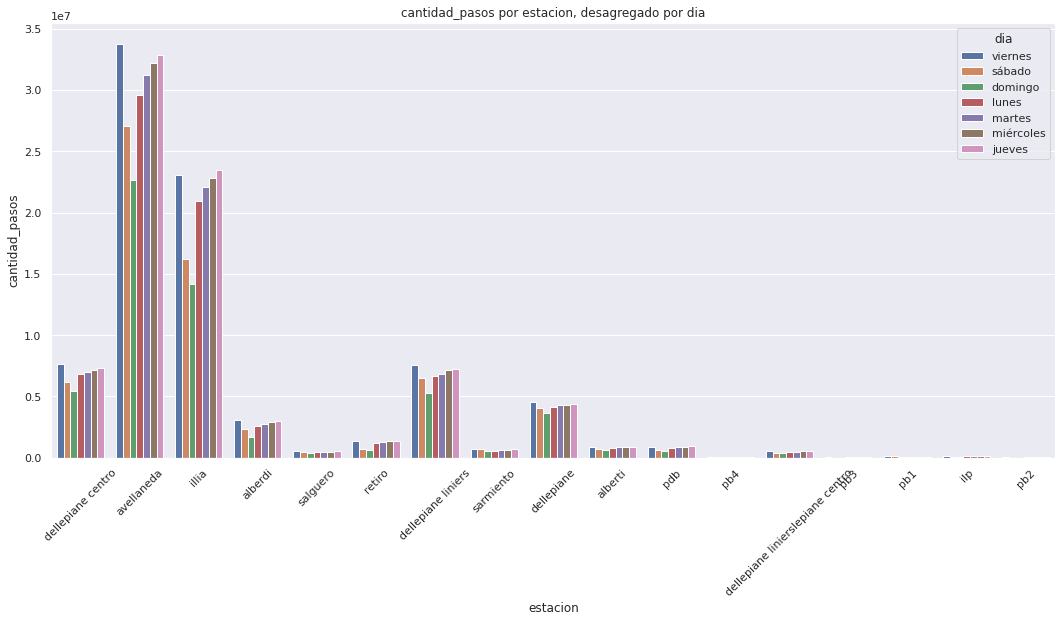

In [26]:
columna_x = 'estacion'
columna_y = 'cantidad_pasos'
cols_hue = ['sentido', 'tipo_vehiculo', 'forma_pago', 'dia']
fun_agregacion = sum

graficar_datos(dataset, columna_x, columna_y, cols_hue, fun_agregacion)

#### Qué se observa en las gráficas

> - Las estaciones por las que más pasa tráfico son: 'illia' y 'avellaneda'; seguidas por 'dellepiane centro' y 'dellepiane liniers' 
> - En general, para cada estación pasan la misma cantidad de vehículos en cada sentido: centro o provincia (están balanceados)
> Al parecer, las estaciones 'dellepiane centro' y 'dellepiane liniers' representa el sentido Centro y Provincia, respectivamente, de la estación 'dellepiane'
> - La mayporía de vehículos que circula por cada estación son livianos
> - Las formas de pago más usadas son: Efectivo y Telepase
> - El Viernes es el día con el mayor tráfico por cada estación. 
> Además, de Domingo a Viernes se tiene un incremento del tráfico, el Sábado decae.  Esto se repite en el tiempo, lo cual nos da una pista de que la serie tiene una estacionalidad semanal

Las siguientes gráficas confirman lo observado anteriormente

##### Cantidad de Pasos por Sentido, desagregado por Estación, Tipo vehículo, Forma pago y Día

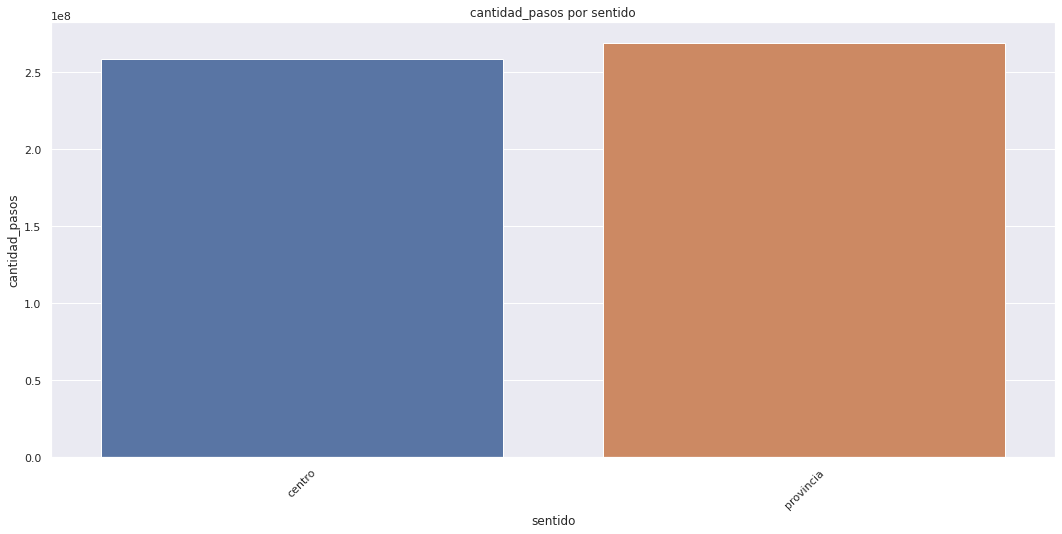

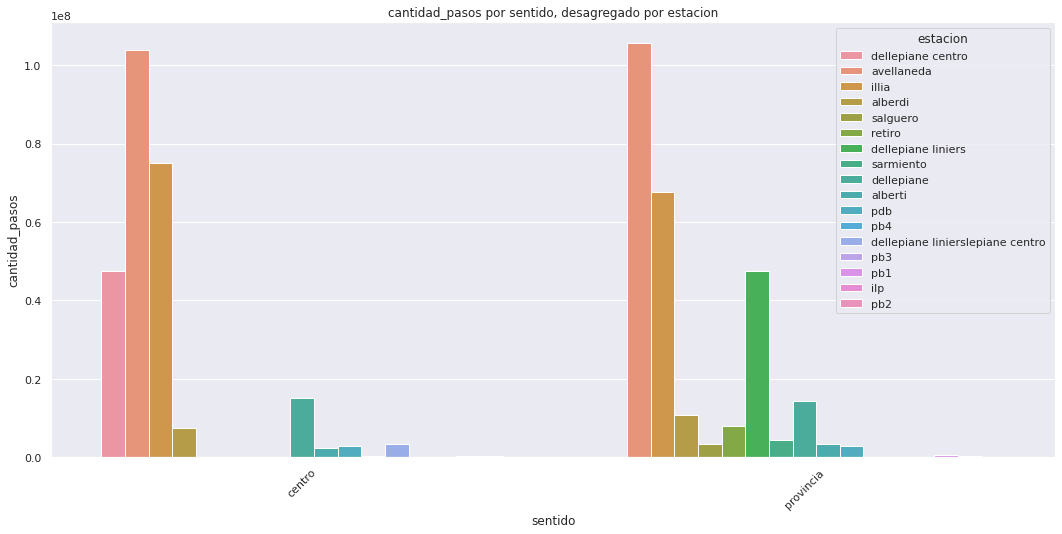

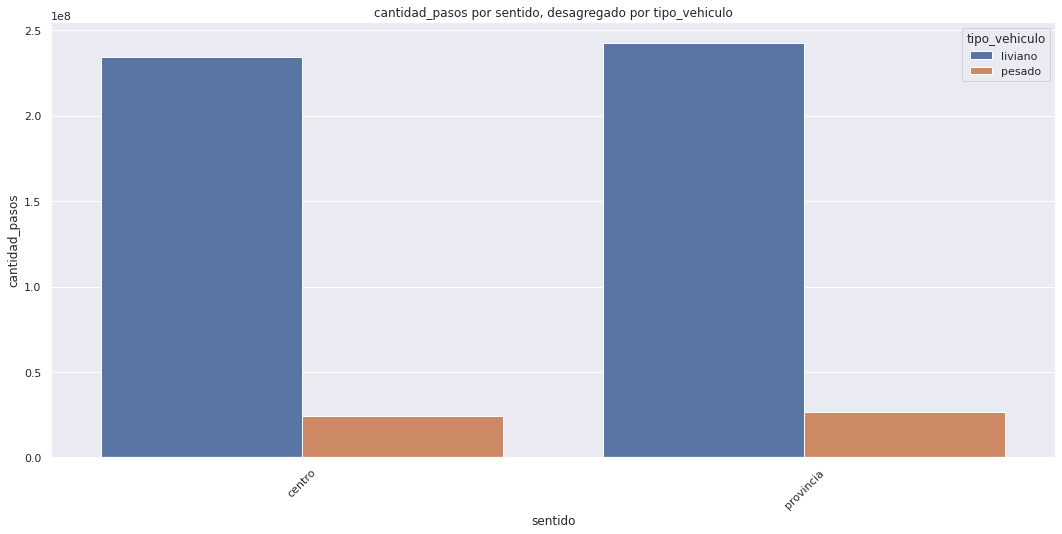

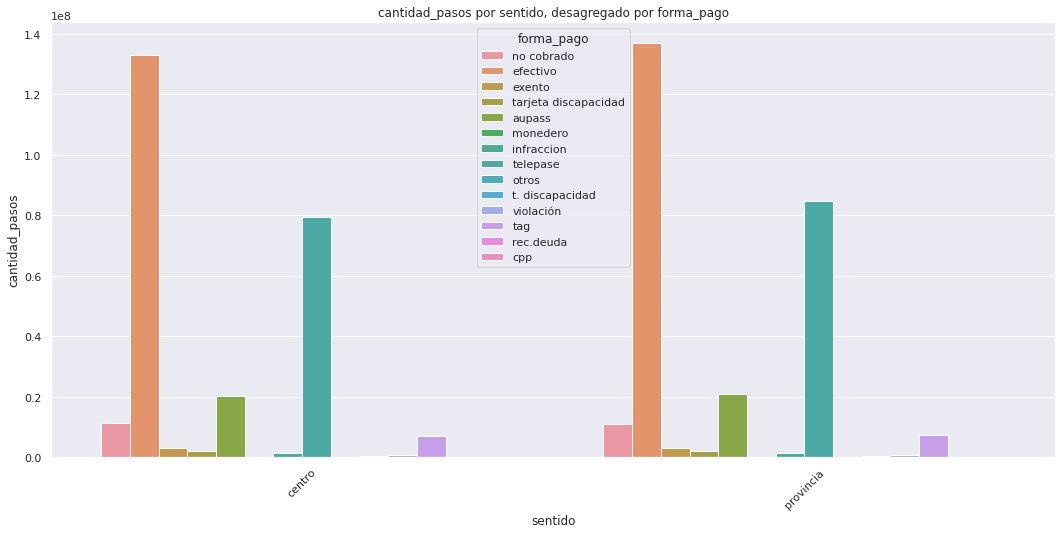

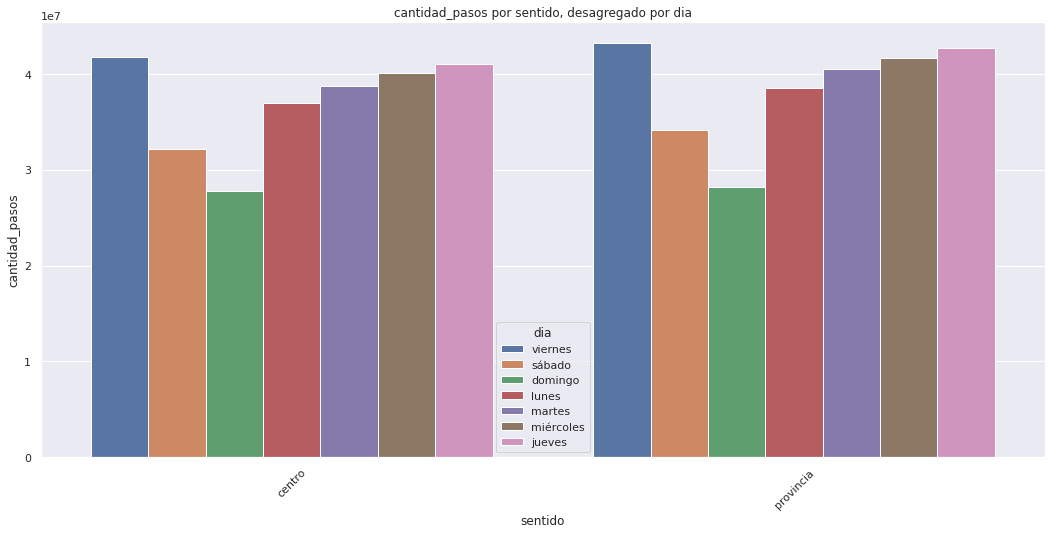

In [27]:
columna_x = 'sentido'
columna_y = 'cantidad_pasos'
cols_hue = ['estacion', 'tipo_vehiculo', 'forma_pago', 'dia']
fun_agregacion = sum

graficar_datos(dataset, columna_x, columna_y, cols_hue, fun_agregacion)

##### Cantidad de Pasos por Tipo vehícuo, desagregado por Estación, Sentido, Forma pago y Día

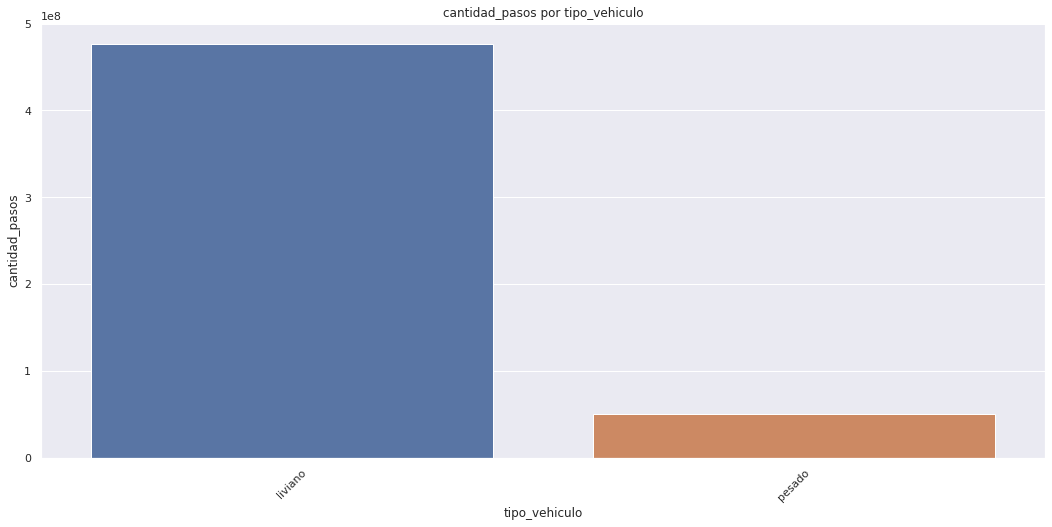

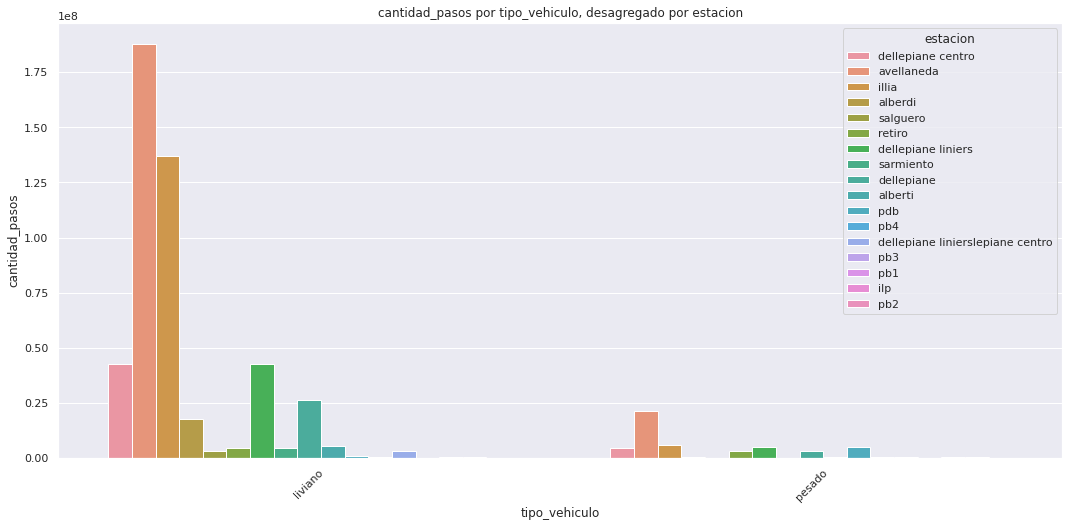

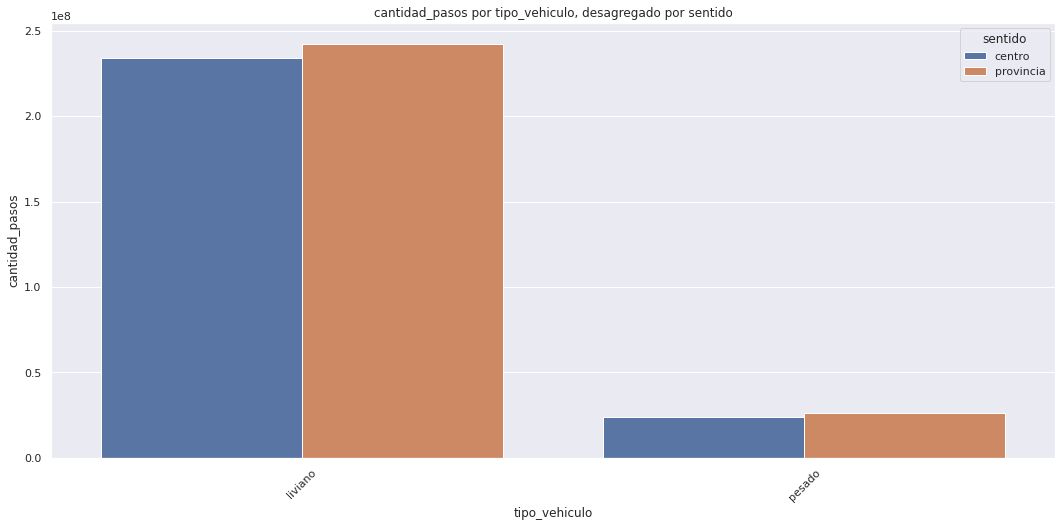

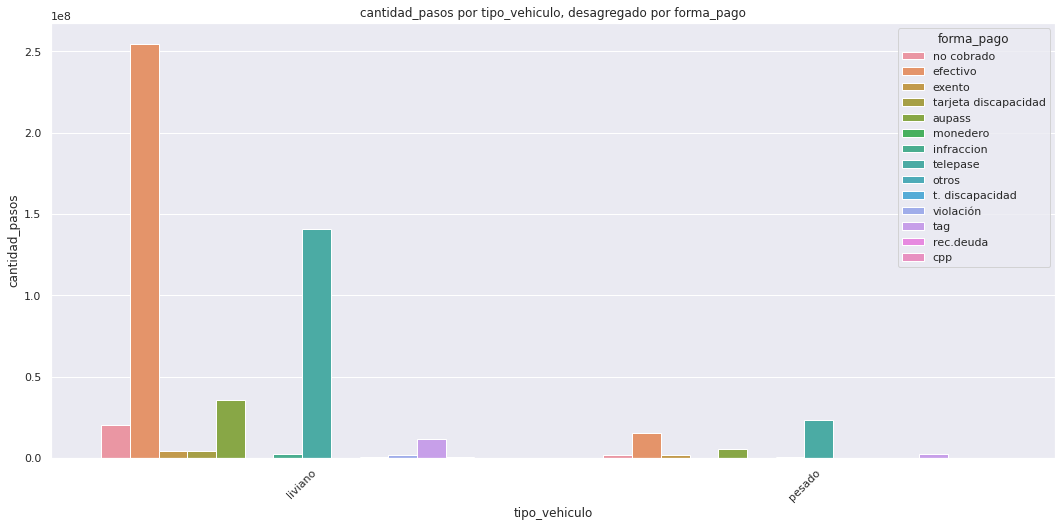

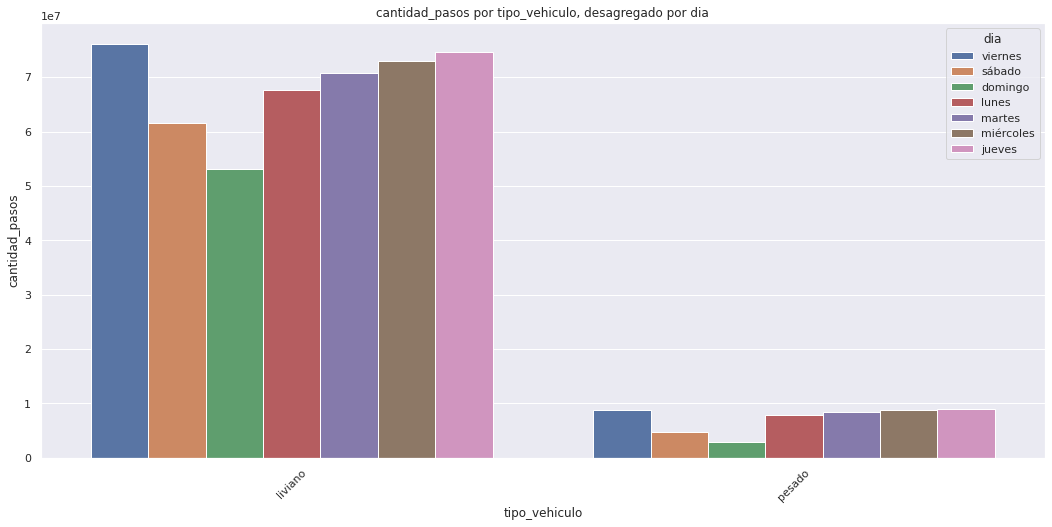

In [28]:
columna_x = 'tipo_vehiculo'
columna_y = 'cantidad_pasos'
cols_hue = ['estacion', 'sentido', 'forma_pago', 'dia']
fun_agregacion = sum

graficar_datos(dataset, columna_x, columna_y, cols_hue, fun_agregacion)

##### Cantidad de Pasos por Forma pago, desagregado por Estación, Sentido, Tipo vehículo y Día

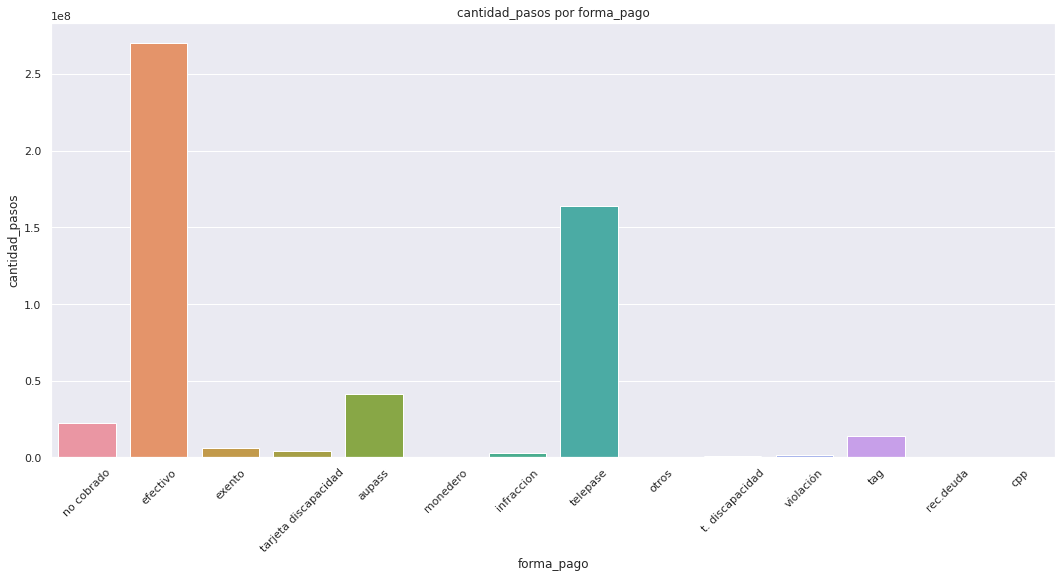

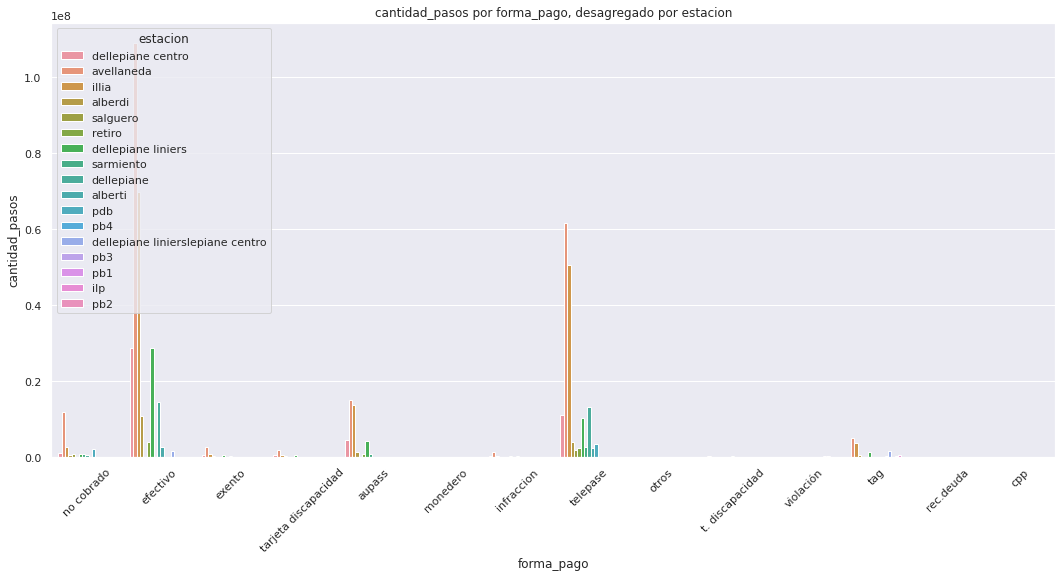

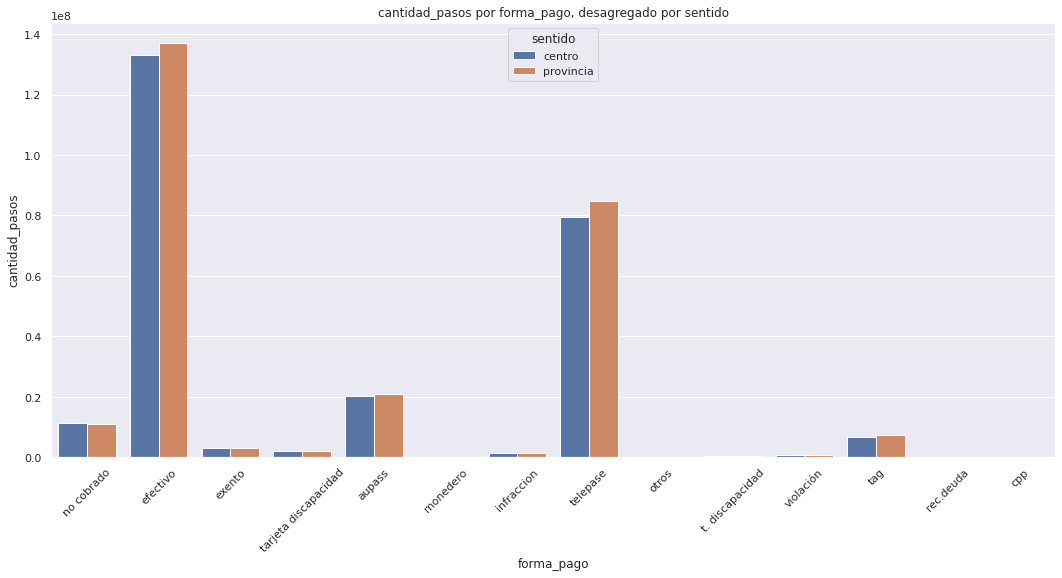

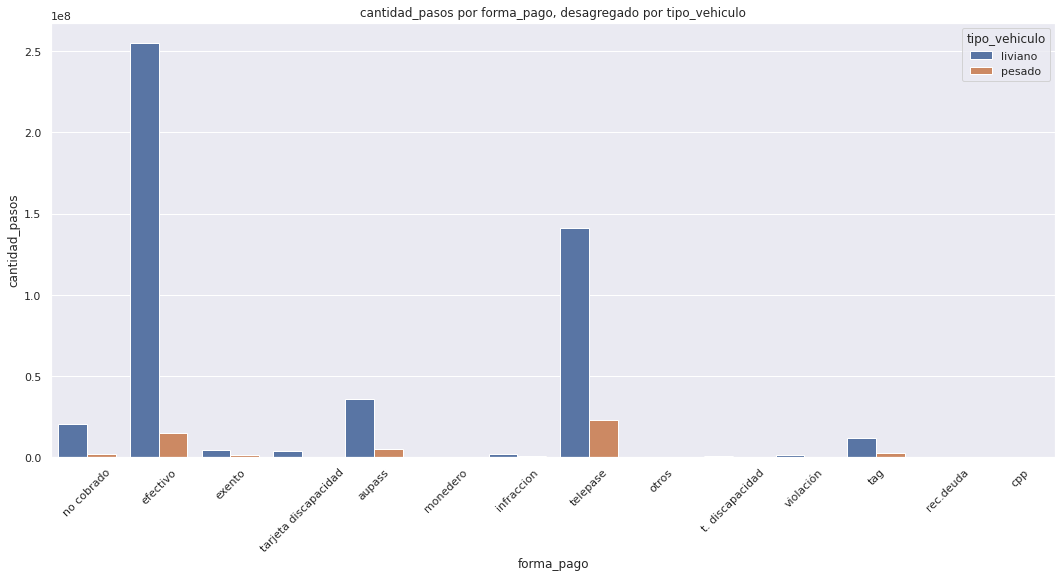

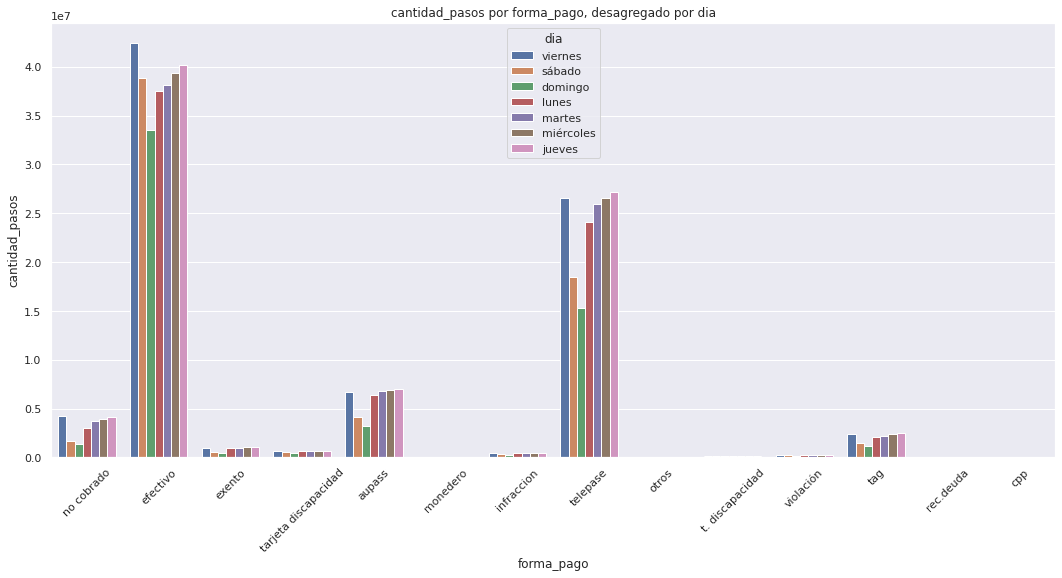

In [29]:
columna_x = 'forma_pago'
columna_y = 'cantidad_pasos'
cols_hue = ['estacion', 'sentido', 'tipo_vehiculo', 'dia']
fun_agregacion = sum

graficar_datos(dataset, columna_x, columna_y, cols_hue, fun_agregacion)

##### Ahora se grafican según el Día
##### Para las gráficas desagregads por Día, se utiliza el Promedio en lugar de la Suma

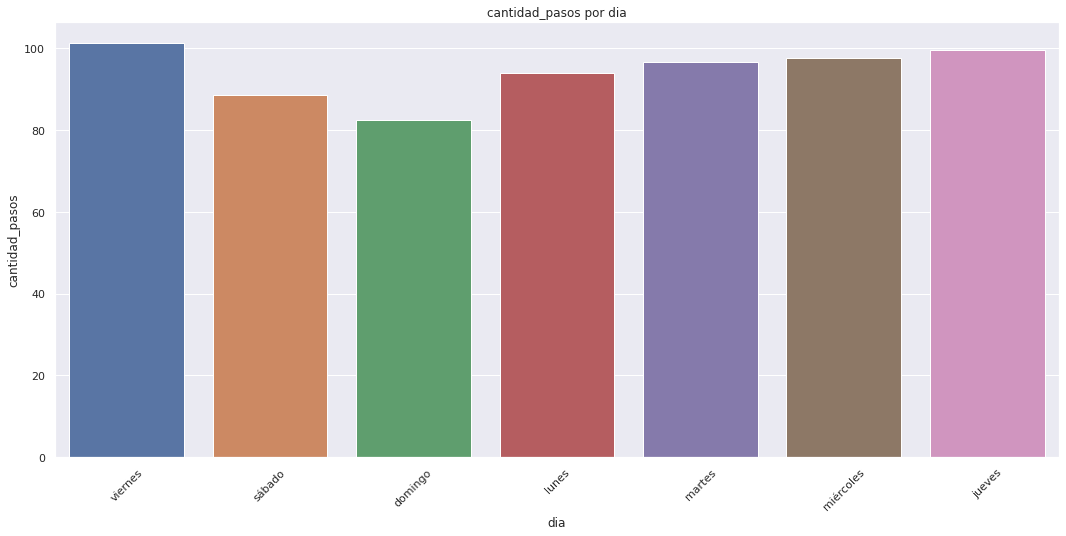

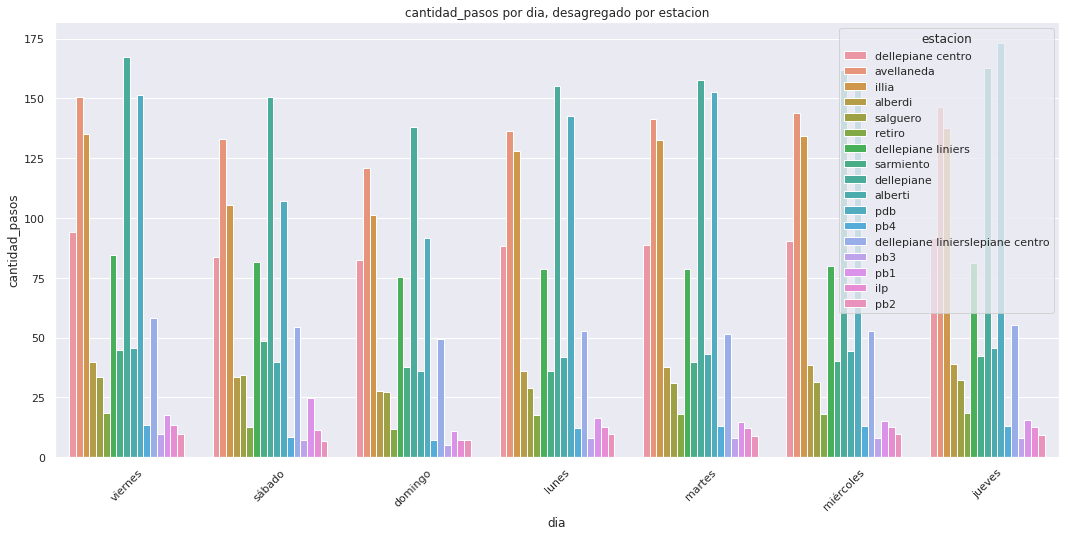

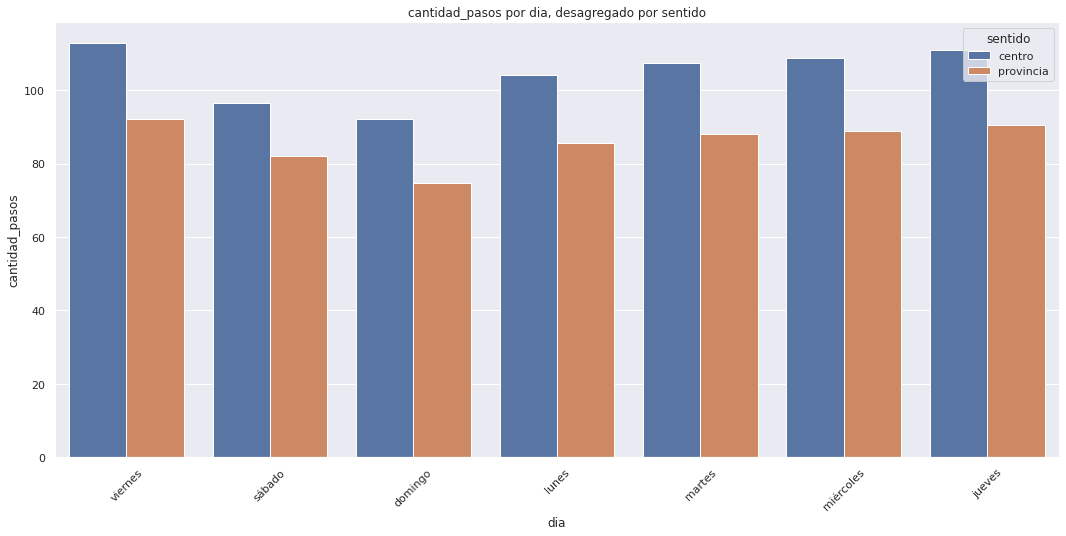

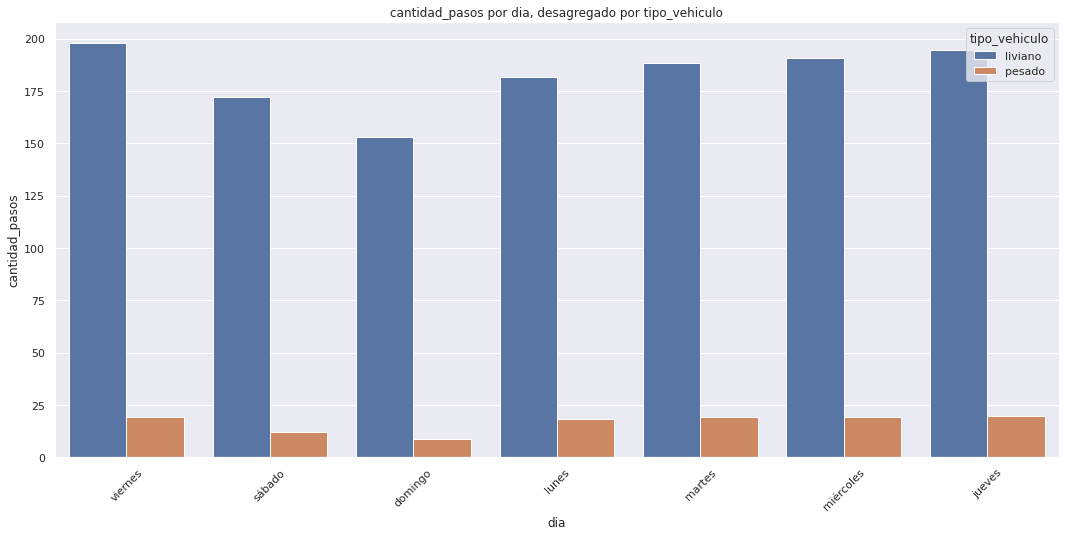

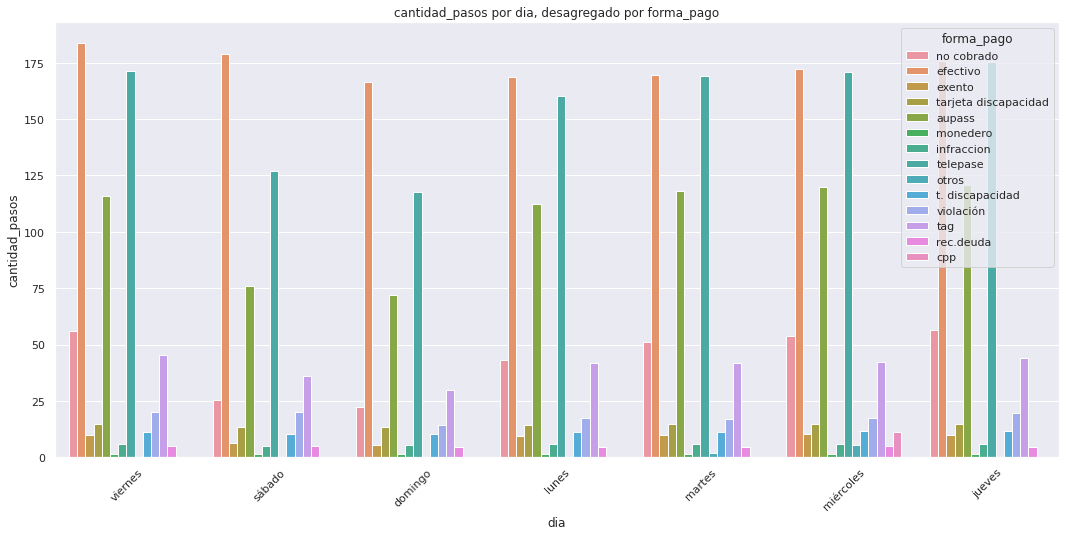

In [30]:
columna_x = 'dia'
columna_y = 'cantidad_pasos'
cols_hue = ['estacion', 'sentido', 'tipo_vehiculo', 'forma_pago']
fun_agregacion = np.mean  ## PROMEDIO

graficar_datos(dataset, columna_x, columna_y, cols_hue, fun_agregacion)

In [31]:
#plt.figure(figsize = (12,6))
#plt.title("Distribución de Cantidad de pasos")
#sns.histplot(data=dataset[dataset["cantidad_pasos"] < 40], x="cantidad_pasos")
#plt.show()

> Las siguientes gráficas contienene las gráficas por hora, con lo cual se tiene el comportamiento día a día en cada hora

In [32]:
#dataset['fecha'].sample(1)#.hour
#type(dataset['fecha'].sample(1))
#dataset['fecha'].dt.hour

#plt.figure(figsize = (12,6))
#sns.histplot(data=dataset[dataset["dia"] == 'viernes'], x="cantidad_pasos")

#dataset[dataset["dia"] == 'viernes']["fecha"].dt.hour

#plt.figure(figsize = (12,6))
#sns.barplot(x=dataset[dataset["dia"] == 'viernes']["fecha"].dt.hour, 
#            y="cantidad_pasos", data=dataset, estimator=np.mean, ci=None)
#plt.show()

##### Promedio de Cantidad de Pasos en cada hora del Día

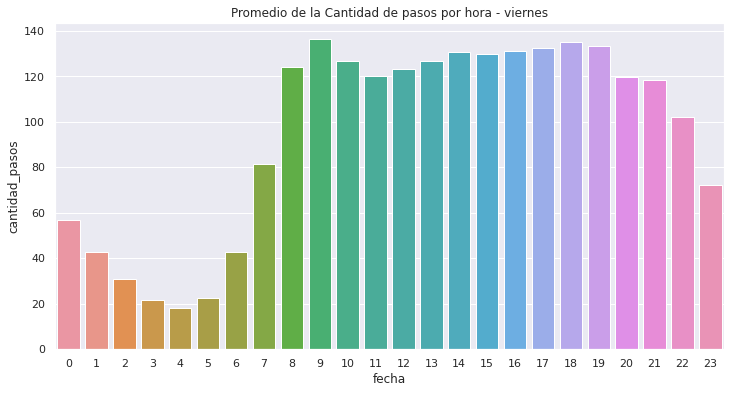

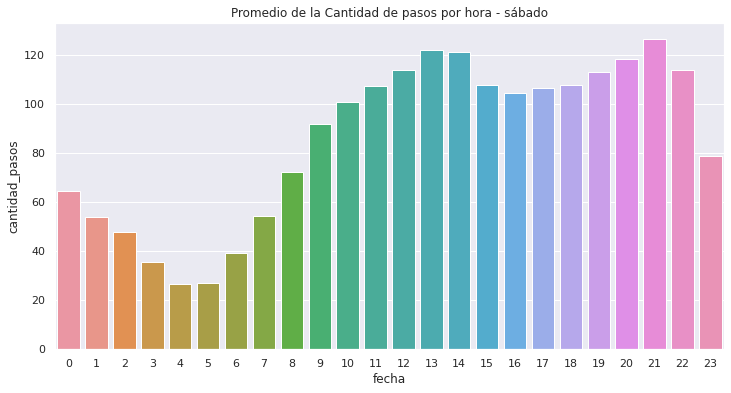

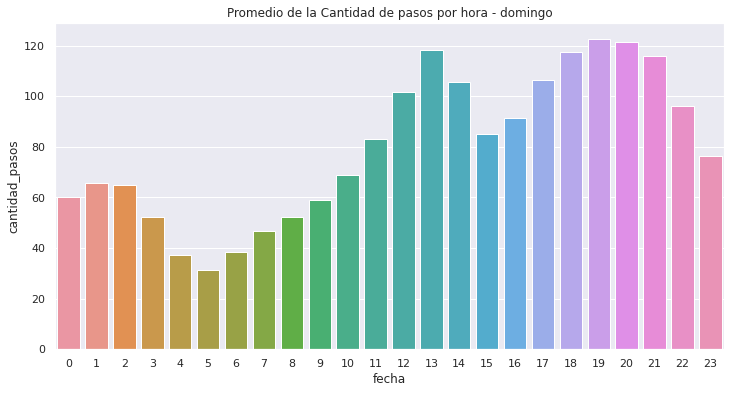

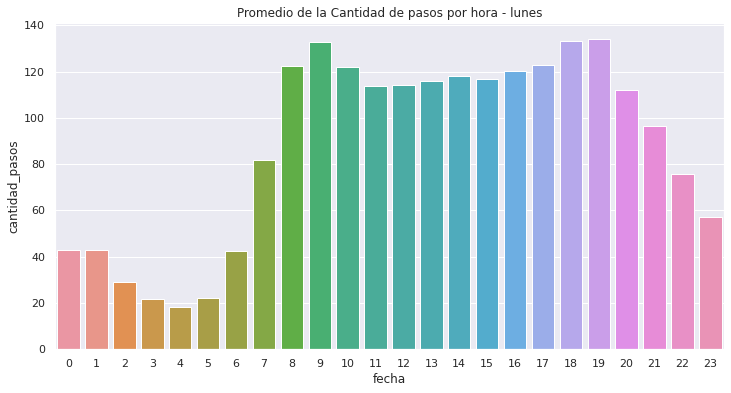

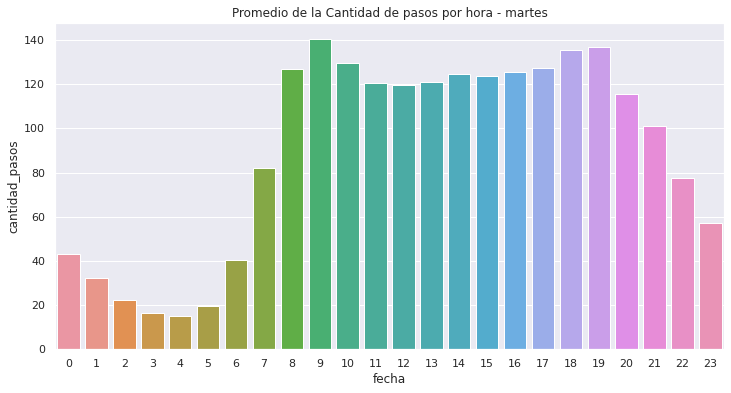

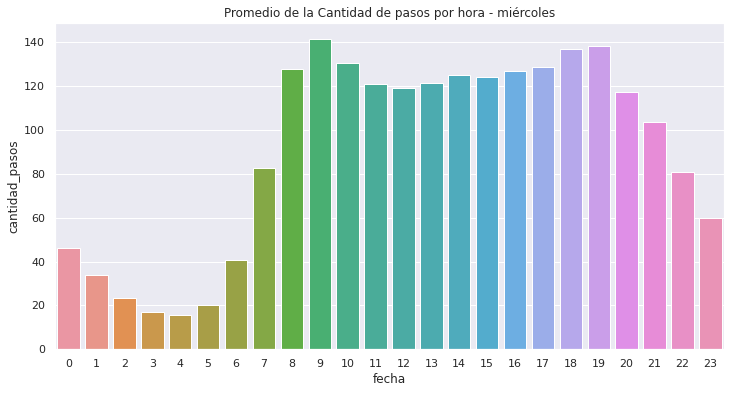

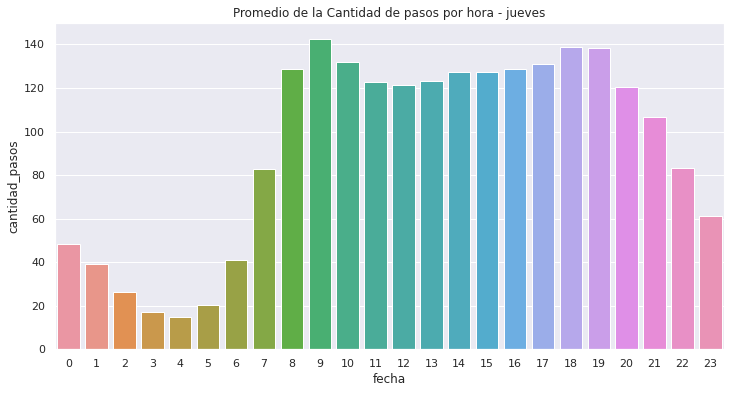

In [33]:
for d in dataset["dia"].unique():
    plt.figure(figsize = (12,6))
    plt.title(str("Promedio de la Cantidad de pasos por hora - ") + d)
    sns.barplot(x=dataset[dataset["dia"] == str(d)]["fecha"].dt.hour, 
                y="cantidad_pasos", data=dataset, estimator=np.mean, ci=None)
    plt.show()

Se observa que de lunes a viernes la hora de mayor tráfico en la mañana es a las 8 - 9 hrs; y en la tarde es a las 18 - 19 hrs.

Por su parte, los fines de semana, sábado y domingo, las horas de mayor tráfico se encuentran las 13 - 14 hrs, y  a las 20 - 21 hrs.

##### Promedio de Cantidad de Pasos en cada hora del día, desagregado por Sentido

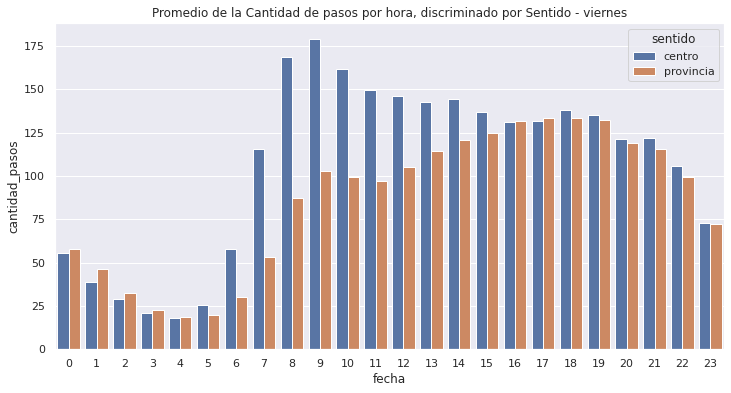

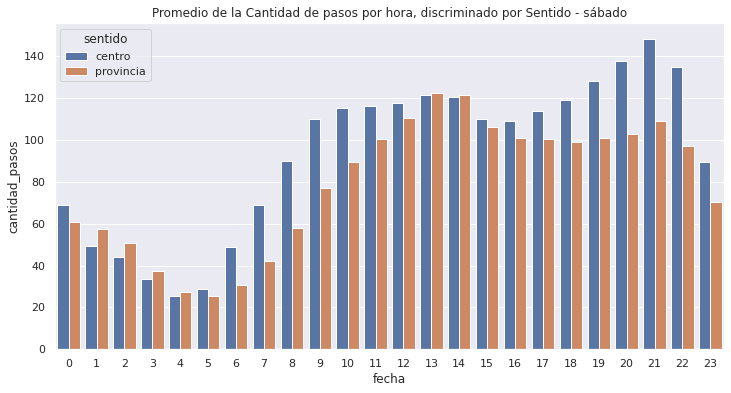

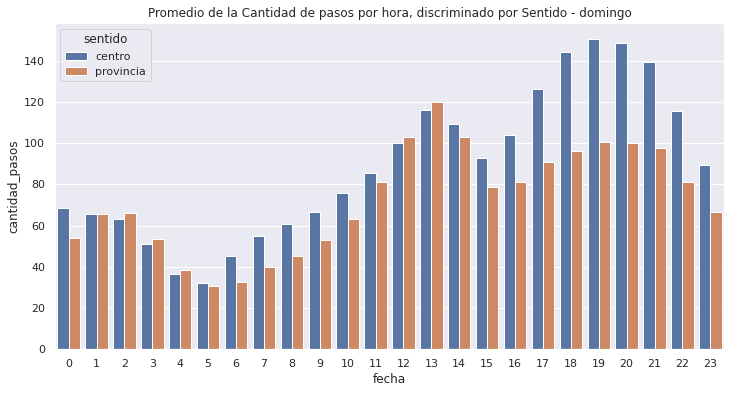

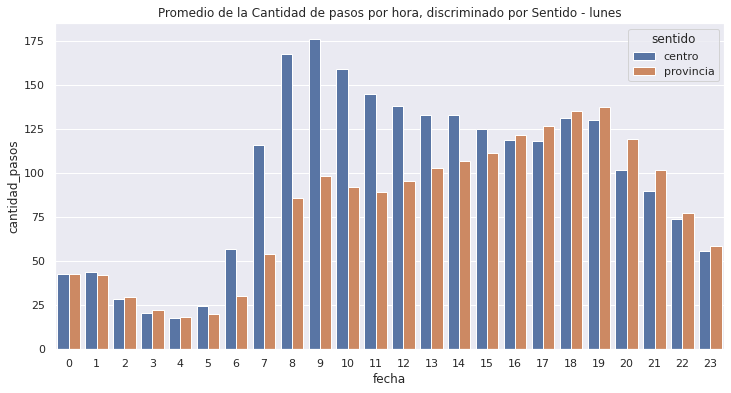

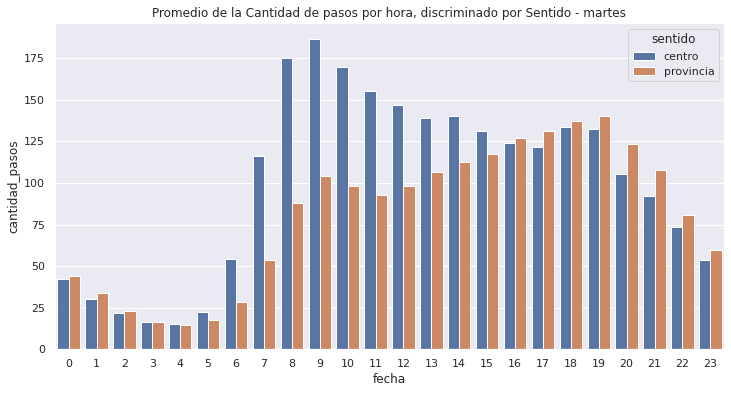

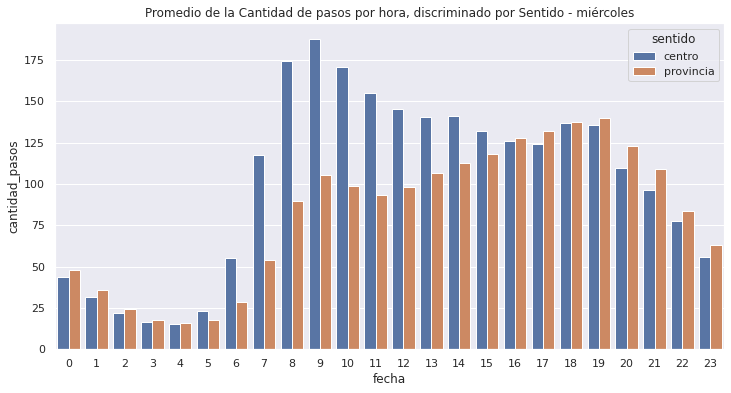

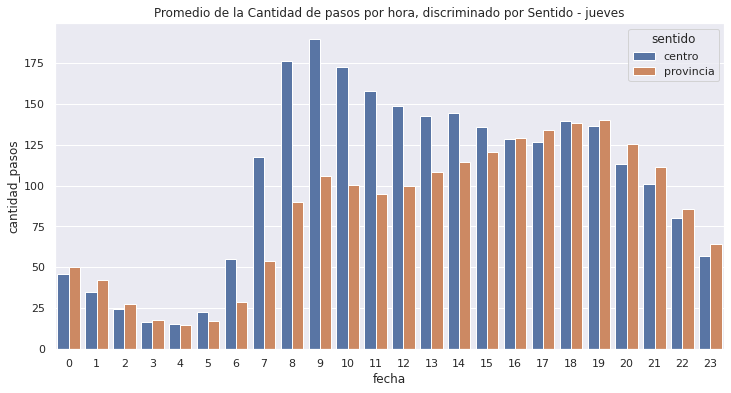

In [34]:
for d in dataset["dia"].unique():
    plt.figure(figsize = (12,6))
    plt.title(str("Promedio de la Cantidad de pasos por hora, discriminado por Sentido - ") + d)
    sns.barplot(x=dataset[dataset["dia"] == str(d)]["fecha"].dt.hour, 
                y="cantidad_pasos", hue='sentido', data=dataset, estimator=np.mean, ci=None)
    plt.show()

Al analizar el sentido por hora, en cada día, se evidencia que en la horas de la mañana hay más tráfico hacia el Centro y en horas de la tarde hay más tráfico hacia la Provincia, cual es consecuente con el hecho de que en la mañana hay flujo de trabajadores hacia la ciudad y en la tarde se viaja hacia la provincia.

In [35]:
# Con la suma
#for d in dataset["dia"].unique():
#    plt.figure(figsize = (12,6))
#    plt.title(str("Total acumulado - ") + d)
#    sns.barplot(x=dataset[dataset["dia"] == str(d)]["fecha"].dt.hour, 
#                y="cantidad_pasos", data=dataset, estimator=sum, ci=None)
#    plt.show()

### Filtrado del dataset antes de trabajar con la serie de tiempo

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**

In [36]:
#Unimos los datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset_illia = pd.concat([data_2020[(data_2020['fecha'] >= "2020-01-01") & (data_2020['fecha'] <= "2020-03-19")],
                    data_2019, data_2018, data_2017, data_2016])

#dataset_illia_total = dataset_illia.copy()

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo, Telepase
mask = np.logical_and(dataset_illia.estacion=='illia', dataset_illia.forma_pago.isin(['efectivo'])) #, 'telepase']))
dataset_illia = dataset_illia[mask]

#Quitamos las columnas que no vamos a utilizar
dataset_illia.drop(columns = ['periodo','hora_inicio','estacion', 'forma_pago'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset_illia['fecha2'] = pd.to_datetime(dataset_illia.fecha) + pd.to_timedelta(dataset_illia.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset_illia.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset_illia.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
dataset_illia.sort_values('fecha', inplace = True)
dataset_illia.reset_index(drop=True, inplace = True)
print("Tamaño del dataset por hora: " + str(dataset_illia.shape))

#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario_illia = dataset_illia.resample('D', on = 'fecha').sum()
print("Tamaño del dataset por día: " + str(diario_illia.shape))
diario_illia.head()

Tamaño del dataset por hora: (363282, 5)
Tamaño del dataset por día: (1540, 1)


cantidad_pasos
fecha                     
2016-01-01           25602
2016-01-02           36136
2016-01-03           37225
2016-01-04           50312
2016-01-05           49907

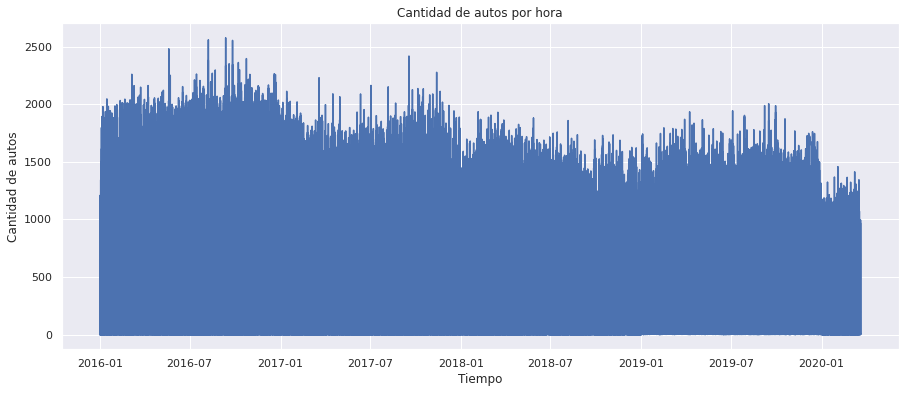

In [37]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
#plt.plot(dataset_illia[dataset_illia.forma_pago.isin(['efectivo'])].fecha, 
#         dataset_illia[dataset_illia.forma_pago.isin(['efectivo'])].cantidad_pasos)
plt.plot(dataset_illia.fecha, dataset_illia.cantidad_pasos)
plt.title('Cantidad de autos por hora')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.show()

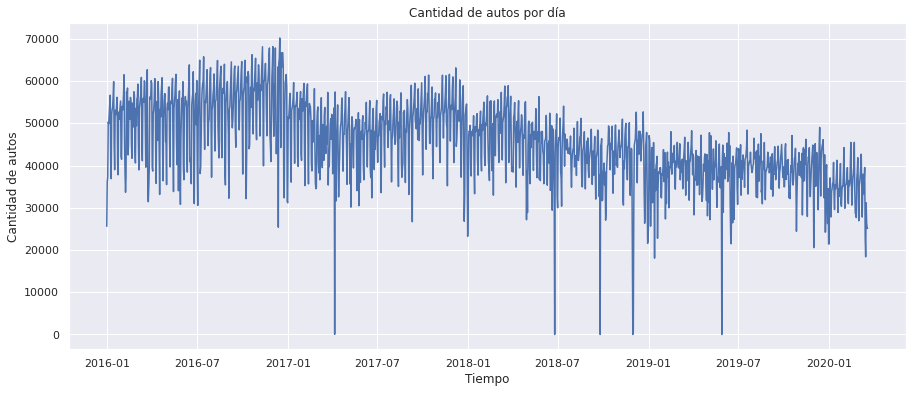

In [38]:
#Graficamos nuestros datos diarios
plt.figure(figsize = (15,6))
plt.plot(diario_illia.index, diario_illia.cantidad_pasos)
plt.title('Cantidad de autos por día')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.show()

Estación **Illia** pago Telepase, hagamos un análisis de **EFECTIVO** vs **TELEPASE**

In [39]:
#Unimos los datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset_illia2 = pd.concat([data_2020[(data_2020['fecha'] >= "2020-01-01") & (data_2020['fecha'] <= "2020-03-19")],
                    data_2019, data_2018, data_2017, data_2016])

#dataset_illia_total = dataset_illia.copy()

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo, Telepase
mask = np.logical_and(dataset_illia2.estacion=='illia', dataset_illia2.forma_pago.isin(['telepase'])) #, 'efectivo']))
dataset_illia2 = dataset_illia2[mask]

#Quitamos las columnas que no vamos a utilizar
dataset_illia2.drop(columns = ['periodo','hora_inicio','estacion', 'forma_pago'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset_illia2['fecha2'] = pd.to_datetime(dataset_illia2.fecha) + pd.to_timedelta(dataset_illia2.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset_illia2.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset_illia2.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
dataset_illia2.sort_values('fecha', inplace = True)
dataset_illia2.reset_index(drop=True, inplace = True)
print("Tamaño del dataset por hora: " + str(dataset_illia2.shape))

#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario_illia2 = dataset_illia2.resample('D', on = 'fecha').sum()
print("Tamaño del dataset por día: " + str(diario_illia2.shape))
#diario_illia2.head()

Tamaño del dataset por hora: (208598, 5)
Tamaño del dataset por día: (1174, 1)


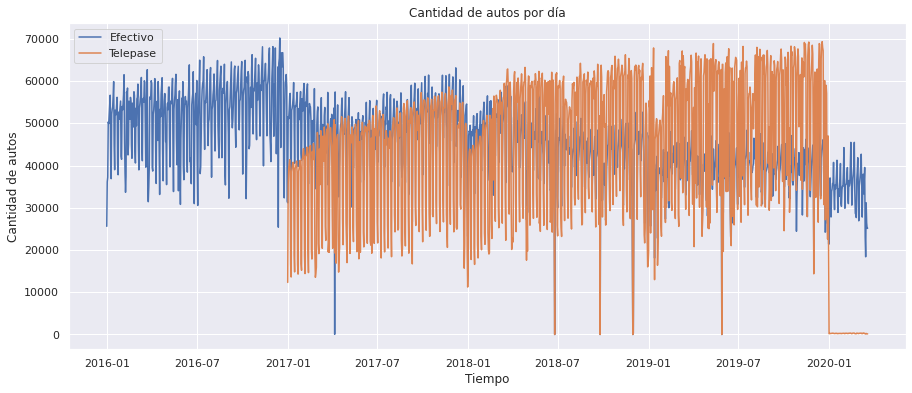

In [40]:
#Graficamos nuestros datos diarios
plt.figure(figsize = (15,6))
plt.plot(diario_illia.index, diario_illia.cantidad_pasos, label='Efectivo')
plt.plot(diario_illia2.index, diario_illia2.cantidad_pasos, label='Telepase')
plt.legend()
plt.title('Cantidad de autos por día')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.show()

>Se observa que desde el 2017 pago el pago por Telepase (naranja) en la estación Illia empieza a darse, lo que hace que desde el 2018 el pago por Efectivo (azul) vaya disminuyendo, es por ello que la tendencia de la serie original es a la baja

## 3. Componentes de la serie

In [41]:
dataset_illia.head()

dia    sentido tipo_vehiculo  cantidad_pasos      fecha
0  viernes     centro       liviano              14 2016-01-01
1  viernes     centro        pesado               3 2016-01-01
2  viernes  provincia       liviano              66 2016-01-01
3  viernes  provincia        pesado               1 2016-01-01
4  viernes  provincia        pesado               4 2016-01-01

In [42]:
#dataset_illia[dataset_illia['fecha'] == '2017-01-01']
#dataset_illia['fecha'].unique()

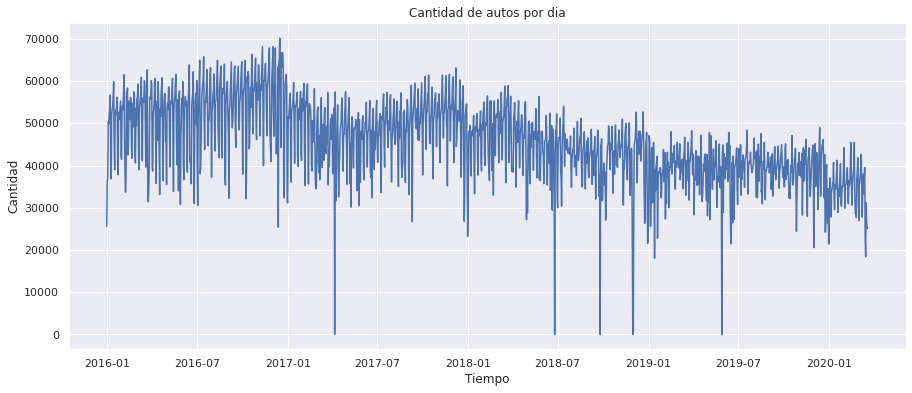

In [43]:
plt.figure(figsize = (15,6))
plt.plot(diario_illia.index, diario_illia.cantidad_pasos)
plt.title('Cantidad de autos por dia')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad')
plt.show()

Validar que la serie esté completa

In [44]:
pd.DataFrame(diario_illia.index).sort_values(by="fecha").diff().value_counts()

fecha 
1 days    1539
dtype: int64

In [45]:
# Verificar que un índice temporal está completo
print("La serie de tiempo está completa? " + 
      str(
          (diario_illia.index == pd.date_range(start=diario_illia.index.min(),
                              end=diario_illia.index.max(),
                              freq=diario_illia.index.freq)).all()
      )
      
     )

La serie de tiempo está completa? True


>Está completa, los datos están de manera diaria

##### Manejo de valires atípicos

In [46]:
diario_illia.describe()

cantidad_pasos
count     1540.000000
mean     45330.568182
std       9387.110845
min          0.000000
25%      39142.500000
50%      45008.500000
75%      52465.750000
max      70203.000000

#### Boxplot

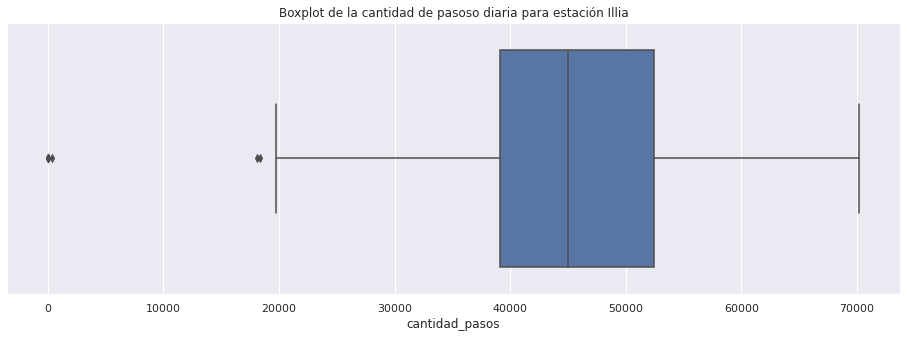

In [47]:
plt.figure(figsize = (16,5))
sns.boxplot(x=diario_illia["cantidad_pasos"])
plt.title('Boxplot de la cantidad de pasoso diaria para estación Illia')
plt.show()

**>>** Cuántos valores hay por debajo del cuantil 25

In [48]:
diario_illia[diario_illia["cantidad_pasos"] < int(diario_illia.describe().loc['25%'])].count() #.value_counts() #.index.sum()

cantidad_pasos    385
dtype: int64

Valor mínimo y máximo para determinar los outliers con la regla de las 3 sigmas

In [49]:
# Valor mínimo y máximo para determinar los outliers con la regla de las 3 sigmas

col_outliers = ['cantidad_pasos']
#mascara_out = []

for col_out in col_outliers:
    valor_medio = diario_illia[diario_illia[col_out].notnull()][col_out].values.mean()
    std = diario_illia[diario_illia[col_out].notnull()][col_out].values.std()
    minimo = valor_medio - 3*std
    maximo = valor_medio + 3*std
    print("\nValores para determinar los outliers: {}".format(col_out))
    
    print("valor_medio: {:0.2f}".format(valor_medio), "\n std: {:0.2f}".format(std), 
      "\n min: {:0.2f}".format(minimo), "\n max: {:0.2f}".format(maximo))


Valores para determinar los outliers: cantidad_pasos
valor_medio: 45330.57 
 std: 9384.06 
 min: 17178.38 
 max: 73482.76


De acuerdo a la gráfica del boxplot y el análisis de la Regla de las 3 Sigmas para detección de Outliers, la cantidad de pasos por debajo de 17,178 son valores atipicos

Son solo 6 valores y son los siguientes

In [50]:
limite_inferior = 17178
print("Cantidad de pasos por debajo de 20 mil: " + str(diario_illia[diario_illia["cantidad_pasos"] < limite_inferior].value_counts().sum()))

diario_illia[diario_illia["cantidad_pasos"] < limite_inferior]

Cantidad de pasos por debajo de 20 mil: 6


cantidad_pasos
fecha                     
2017-04-06              40
2018-06-25               0
2018-09-25               0
2018-11-30               0
2018-12-01             350
2019-05-29               0

>Dichos valores atípicos se cambian por NAN

In [51]:
diario_illia.cantidad_pasos[diario_illia.cantidad_pasos < limite_inferior] = np.nan

In [52]:
diario_illia.isna().sum()

cantidad_pasos    6
dtype: int64

> Se rellenan los NAN haciendo una interpolación de datos

In [53]:
diario_illia = diario_illia.interpolate()

>Ya no hay valores atípicos

In [54]:
diario_illia.isna().sum()

cantidad_pasos    0
dtype: int64

>Nuevamente se ajusta el tipo de datos del dataset

In [55]:
diario_illia.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1540 entries, 2016-01-01 to 2020-03-19
Freq: D
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cantidad_pasos  1540 non-null   float64
dtypes: float64(1)
memory usage: 24.1 KB


In [56]:
# Tipo de dato entero acorde con el rango de cada variable
col_dtypes= {'cantidad_pasos': np.int32}
diario_illia = diario_illia.astype(col_dtypes)

In [57]:
diario_illia.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1540 entries, 2016-01-01 to 2020-03-19
Freq: D
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   cantidad_pasos  1540 non-null   int32
dtypes: int32(1)
memory usage: 18.0 KB


Se grafica nuevamente la serie

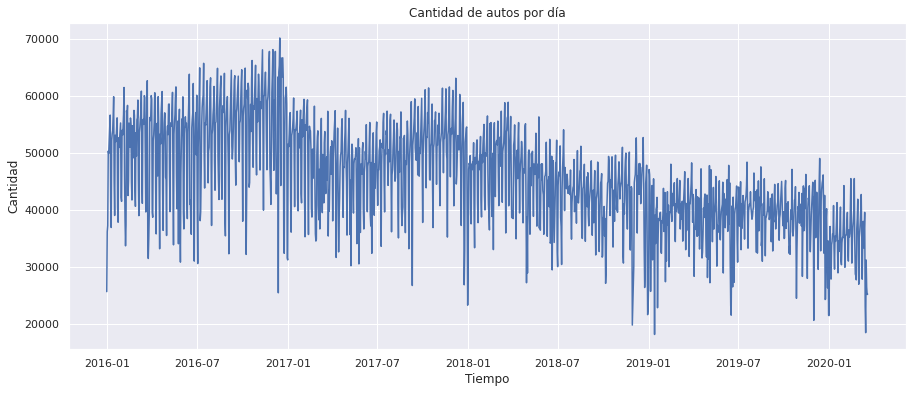

In [58]:
plt.figure(figsize = (15,6))
plt.plot(diario_illia.index, diario_illia.cantidad_pasos)
plt.title('Cantidad de autos por día')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad')
plt.show()

> Se grafica año por año

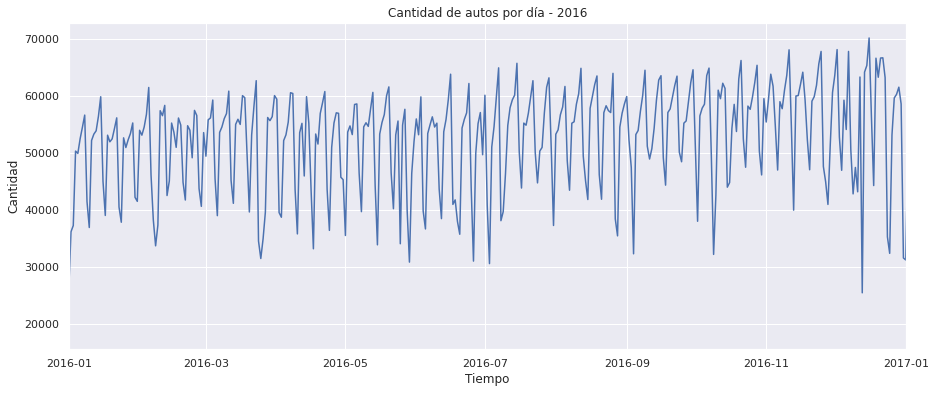

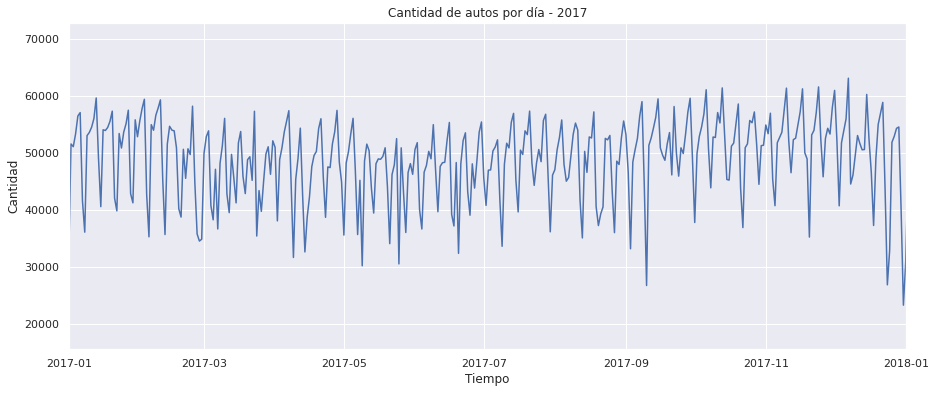

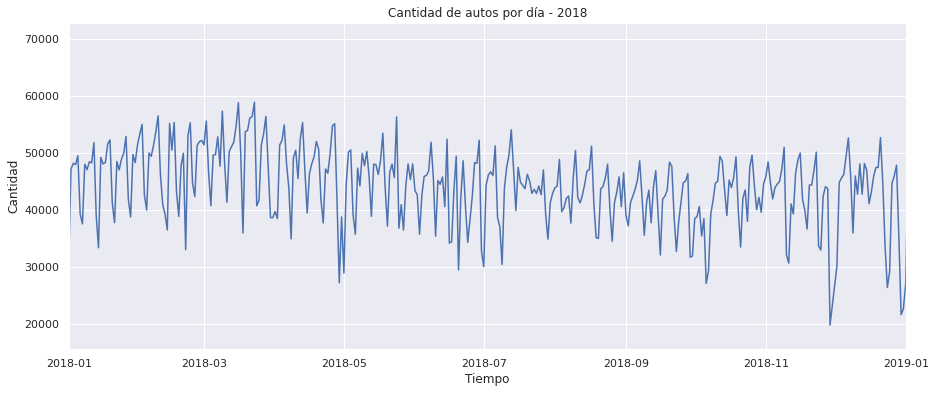

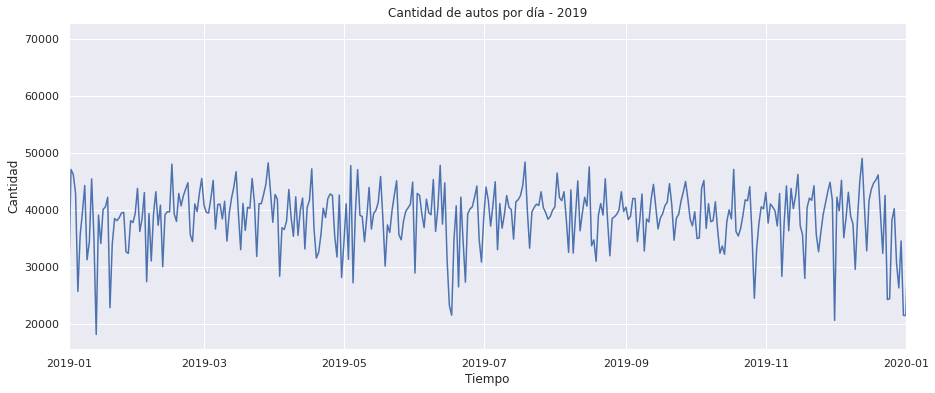

In [59]:
for anio in [2016, 2017, 2018, 2019]:
    plt.figure(figsize = (15,6))
    plt.plot(diario_illia.index, diario_illia.cantidad_pasos)
    plt.title('Cantidad de autos por día - ' + str(anio))
    plt.xlabel('Tiempo')
    plt.ylabel('Cantidad')
    plt.xlim(datetime.date(anio,1,1), datetime.date(anio+1,1,1))
    plt.show()

Se observa que entre 2016 a 2018 el promedio está alrededor de 50 mil, y para el año 2019 la serie está por debajo de ese promedio y los datos de este año son más ruidosos, no se evidencia claramente una estacionalidad

In [60]:
#plt.figure(figsize = (15,6))
#plt.plot(diario_illia.index, diario_illia.cantidad_pasos)
#plt.title('Cantidad de autos por día - 2016')
#plt.xlabel('Tiempo')
#plt.ylabel('Cantidad')
#plt.xlim(datetime.date(2016,1,1), datetime.date(2017,1,1))
#plt.show()

> Veamos cómo se comporta el último trimestre de 2019 y los primeros meses de 2020

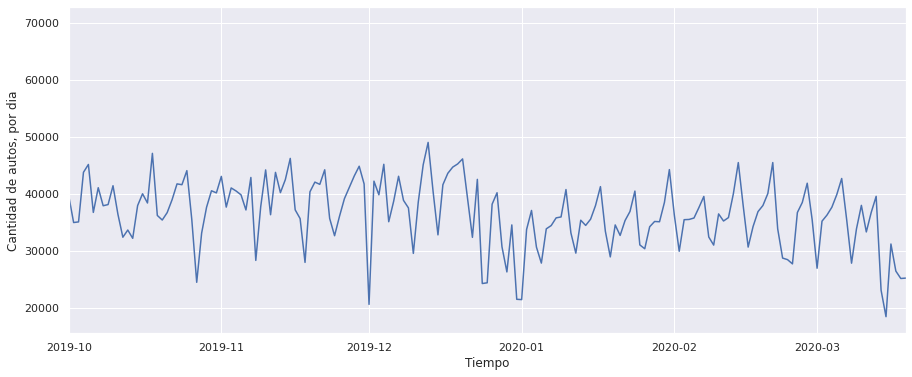

In [61]:
plt.figure(figsize = (15,6))
plt.plot(diario_illia.index, diario_illia.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.xlim(datetime.date(2019,10,1), datetime.date(2020,3,19))
plt.show()

> Se haya la tendencia de la serie de manera gráfica > ventana móvil y promedio

In [62]:
ventana = 30*2*2 #int(365*2/7)
diario_promedio_tendencia = diario_illia.cantidad_pasos.rolling(window=ventana, center = True).mean()
diario_promedio_tendencia

fecha
2016-01-01   NaN
2016-01-02   NaN
2016-01-03   NaN
2016-01-04   NaN
2016-01-05   NaN
              ..
2020-03-15   NaN
2020-03-16   NaN
2020-03-17   NaN
2020-03-18   NaN
2020-03-19   NaN
Freq: D, Name: cantidad_pasos, Length: 1540, dtype: float64

In [63]:
#diario.isna().sum()

De cuánto es la ventana?

In [64]:
diario_promedio_tendencia.isna().sum()

119

In [65]:
#diario_promedio_tendencia.sample(5)

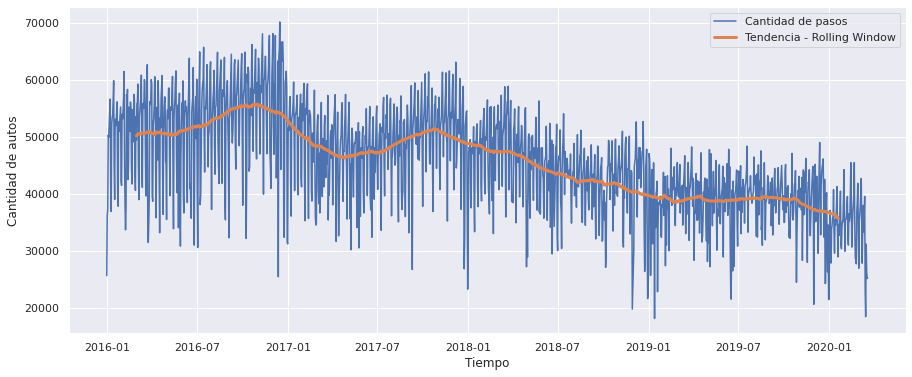

In [66]:
plt.figure(figsize = (15,6))
plt.plot(diario_illia.index, diario_illia.cantidad_pasos, label = 'Cantidad de pasos')
plt.plot(diario_promedio_tendencia, lw = 3, label = 'Tendencia - Rolling Window')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
#plt.xlim(datetime.date(2018,1,1), datetime.date(2018,10,1))
plt.show()

#### Componenetes de la serie

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [68]:
#result = seasonal_decompose(diario_illia['2017-01-01':'2017-12-31'].cantidad_pasos, model='additive')  #model='multiplicative'
result = seasonal_decompose(diario_illia.cantidad_pasos, model='additive')  #model='multiplicative'

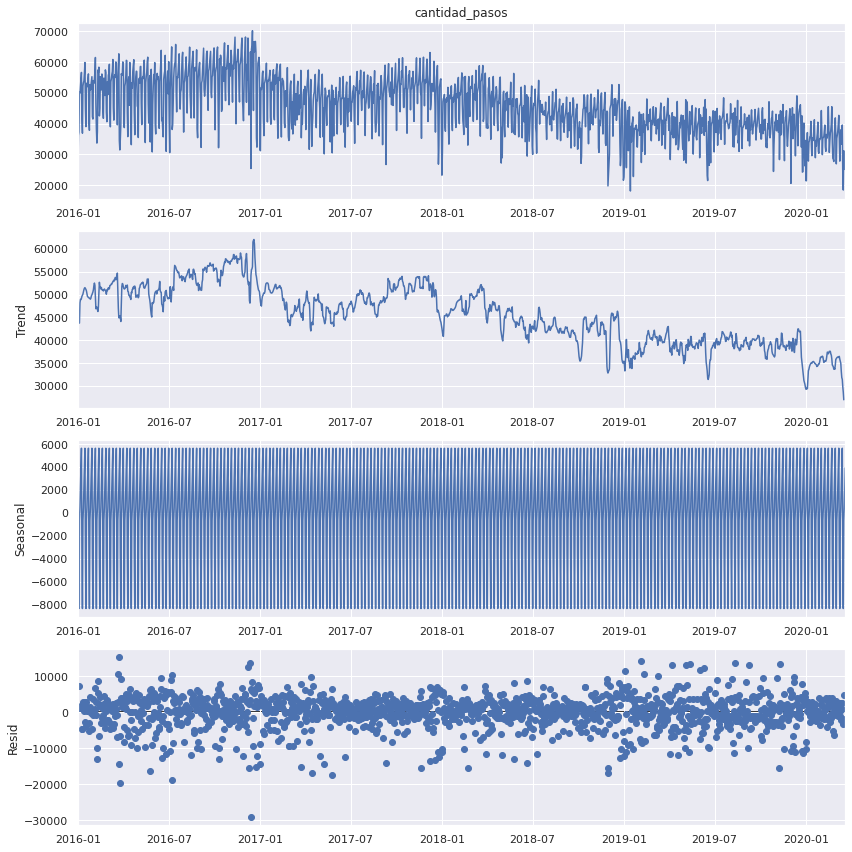

In [69]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

Gráfico de densidad del Residuo

<AxesSubplot:xlabel='resid', ylabel='Count'>

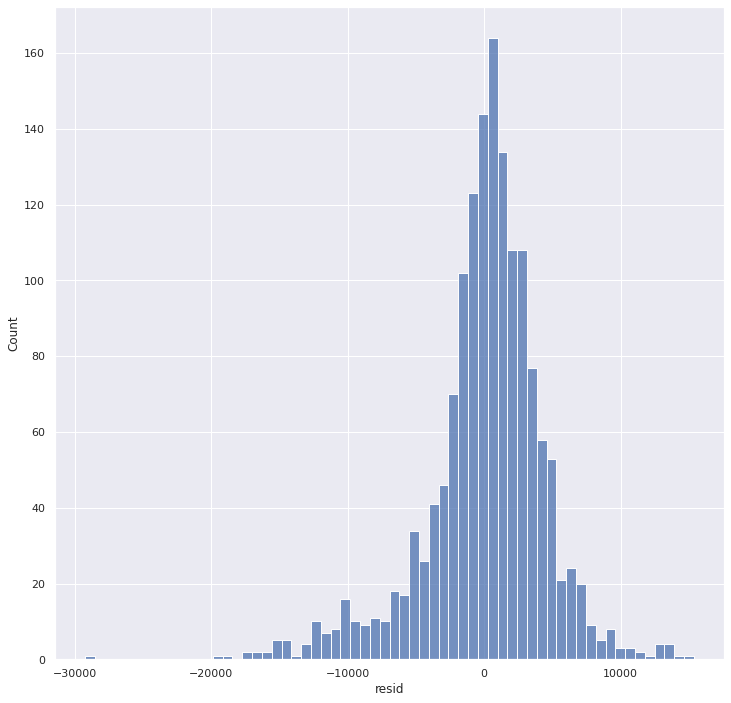

In [70]:
sns.histplot(result.resid)

La densidad del residuo es levemente asimétrica, lo que indica que no se tiene ruido blanco puro

#### Autocorrelación

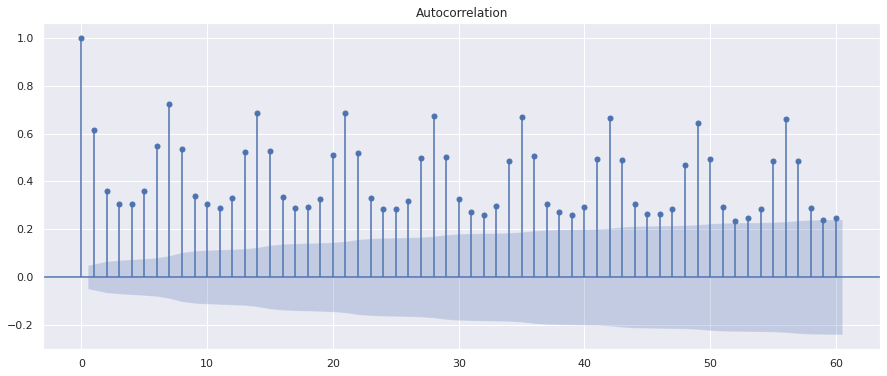

In [71]:
# Gráfico autocorrelación
fig, ax = plt.subplots(figsize = (15,6))
plot_acf(diario_illia.cantidad_pasos, ax=ax, lags=60)
plt.show()

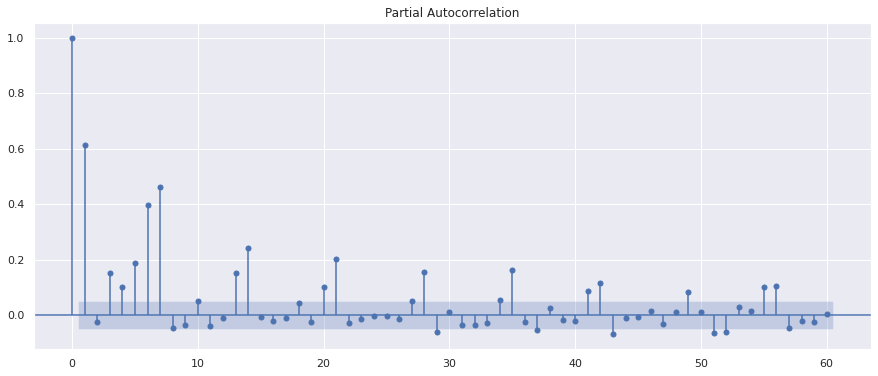

In [72]:
# Gráfico autocorrelación parcial
fig, ax = plt.subplots(figsize = (15,6))
plot_pacf(diario_illia.cantidad_pasos, ax=ax, lags=60)
plt.show()

Los gráficos de autocorrelación y autocorrelación parcial muestran una clara asociación entre la Cantidad de pasos de un día y los días de la semana inmediatanemte anterior; así como entre la Cantidad de pasos de un día y ese mismo día en la semanas anteriores (4 semanas anteriores). 

Sin embargo, se evidencia que la serie no es estacionaria completamente.

#### Evaluar la estacionalidad

Valor p> 0.05: No se rechaza la hipótesis nula (H0), los datos tienen una raíz unitaria y no son estacionarios.

valor p <= 0.05: Rechaza la hipótesis nula (H0), los datos no tienen raíz unitaria y son estacionarios.

In [73]:
#Augmented Dickey-Fuller test 
from statsmodels.tsa.stattools import adfuller
X = diario_illia.cantidad_pasos

result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.018995
p-value: 0.746274
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


##### Dado que p > 0.05, la serie no es estacionaria

## 4. Predicción a Futuro - One-Step Prediction

In [74]:
#diario_illia['2017-01-01':'2017-01-05']
#diario_illia.iloc[0:5]
#diario_illia.iloc[len(diario_illia)-6:]

In [75]:
diario_illia_final = diario_illia.cantidad_pasos.copy()

In [76]:
diario_illia_final.head()

fecha
2016-01-01    25602
2016-01-02    36136
2016-01-03    37225
2016-01-04    50312
2016-01-05    49907
Freq: D, Name: cantidad_pasos, dtype: int32

**>>** Se usa 3 meses de datos para predecir el valor siguiente

In [77]:
look_back = 30*3

In [78]:
N = diario_illia_final.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape, N)

(1449, 90) (1449,) 1540


In [79]:
#Llenamos los X e y

for i in range(X.shape[0]):
    X[i,:] = diario_illia_final.iloc[i:i+look_back]
    y[i] = diario_illia_final.iloc[i+look_back]

In [80]:
print(X.shape, y.shape, N)

(1449, 90) (1449,) 1540


**>>** Se constuye los conjuntos de TRAINT y de TEST

In [81]:
#N_train = int(365*3*0.75 - look_back) # cantidad de instancias que vamos a usar para entrenar. 
#N_test = int(365*3*0.25) #cantidad de puntos que vamos a usar para evaluar

N_train = int(diario_illia_final.shape[0]*0.85 - look_back) # cantidad de instancias que vamos a usar para entrenar. 
N_test = int(diario_illia_final.shape[0]*0.15) #cantidad de puntos que vamos a usar para evaluar

N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
#print(X_train.shape, y_train.shape)
print("Tamaño conjunto X_train: " + str(X_train.shape), ". Tamaño conjunto y_train: " + str(y_train.shape))

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print("Tamaño conjunto X_test: " + str(X_test.shape), ". Tamaño conjunto y_test: " + str(y_test.shape))

Tamaño conjunto X_train: (1219, 90) . Tamaño conjunto y_train: (1219,)
Tamaño conjunto X_test: (230, 90) . Tamaño conjunto y_test: (230,)


#### Modelo de Referencia Benchmark - Random Forest

In [82]:
# Se define una función que permite evaluar los modelos

def evaluar_modelos(modelos, modelos_obj, X_train, X_test, y_train, y_test ):
    '''
    Tipo de elemento: función
    Nombre: evaluar_modelos
    
    Descripción:
        Realiza el gráfico para evaluación de modelos de regresión
    
    Argumentos:
        modelos       >> lista con los títulos de los modelos
        modelos_obj   >> lista con los objetos de los modelos ya entrenados
        X_train, X_test, y_train, y_test  >> Conjuntos de datos definidos por el train-test-split
    
    Retorna:
        Nada
    '''
    
    for i, model in enumerate(modelos_obj):
        print(type(model))
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        print(f'Modelo: {modelos[i]}')
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
        print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

        plt.figure(figsize=(16, 6))
        #plt.figure(figsize = (8,4))

        plt.subplot(1,2,1)
        sns.distplot(y_train - y_train_pred, bins = 10, label = 'train')
        sns.distplot(y_test - y_test_pred, bins = 10, label = 'test')
        #sns.displot(y_train - y_train_pred, bins = 20, label = 'train')
        #sns.displot(y_test - y_test_pred, bins = 20, label = 'test')    
        plt.xlabel('errores')
        plt.legend()

        ax = plt.subplot(1,2,2)
        ax.scatter(y_test,y_test_pred, s =2)    
        lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
        ]

        ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        plt.xlabel('y (test)')
        plt.ylabel('y_pred (test)')

        plt.tight_layout()
        plt.show()

In [83]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [84]:
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs = -1)

In [85]:
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

Cuáles son los features de importancia para este modelo

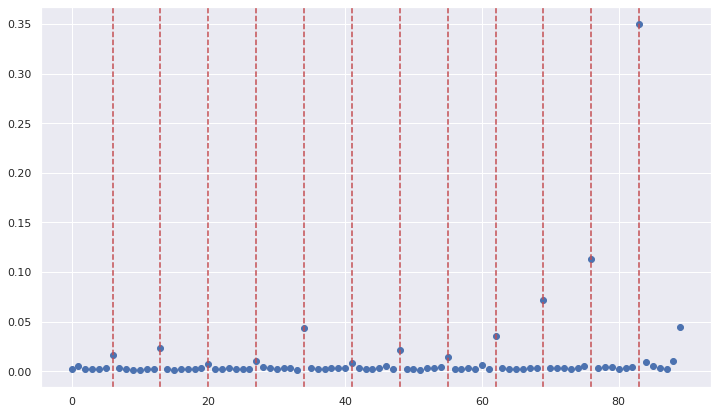

In [86]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
for x in np.arange(start=6, stop=int(look_back), step=7): #np.arange(3)*52:
    plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

Tal como se veía en las gráficas de autocorrelación, los features de importancia son los días de la semana anterior y el mismo día de las tres/cuatro semanas anteriores.

#### Predicciones

In [87]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

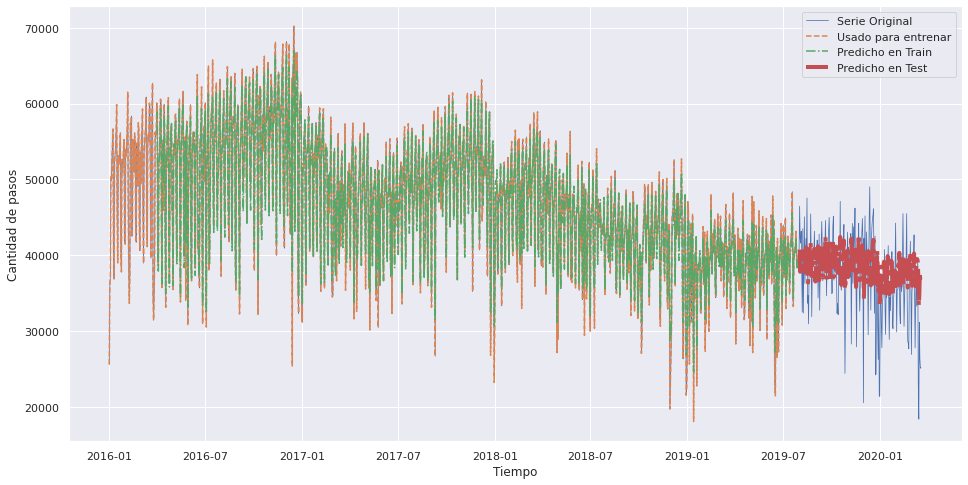

In [88]:
plt.figure(figsize=(16,8))
offset = -1
plt.plot(diario_illia_final.index[:length_total], diario_illia_final[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario_illia_final.index[:N_train + look_back], diario_illia_final[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario_illia_final.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario_illia_final.index[N_train+look_back: length_total + offset], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

Hacemos zoom sobre la predicción de los datos de TEST

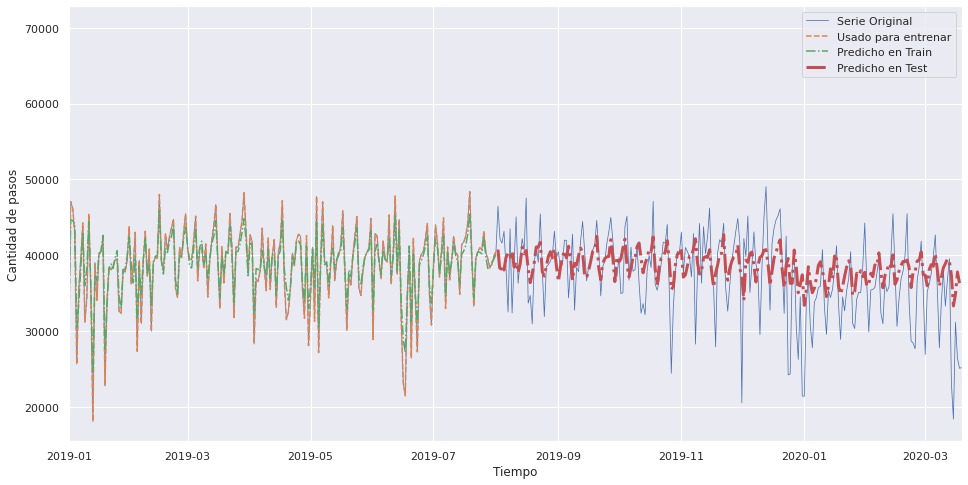

In [89]:
plt.figure(figsize=(16,8))
plt.plot(diario_illia_final.index[:length_total], diario_illia_final[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario_illia_final.index[:N_train + look_back], diario_illia_final[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario_illia_final.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario_illia_final.index[N_train+look_back: length_total+ offset], y_test_pred,'-.', lw = 3, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.xlim(datetime.date(2019,1,1), datetime.date(2020,3,19))
plt.show()

In [90]:
#MSE = mean_squared_error(y_train, y_train_pred)
#print('Error en Train:',np.sqrt(MSE))

#MSE = mean_squared_error(y_test, y_test_pred)
#print('Error en Test:',np.sqrt(MSE))

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Modelo: Radmon Forest
Raíz del error cuadrático medio en Train: 1864.0648862021465
Raíz del error cuadrático medio en Test: 4729.849941926736


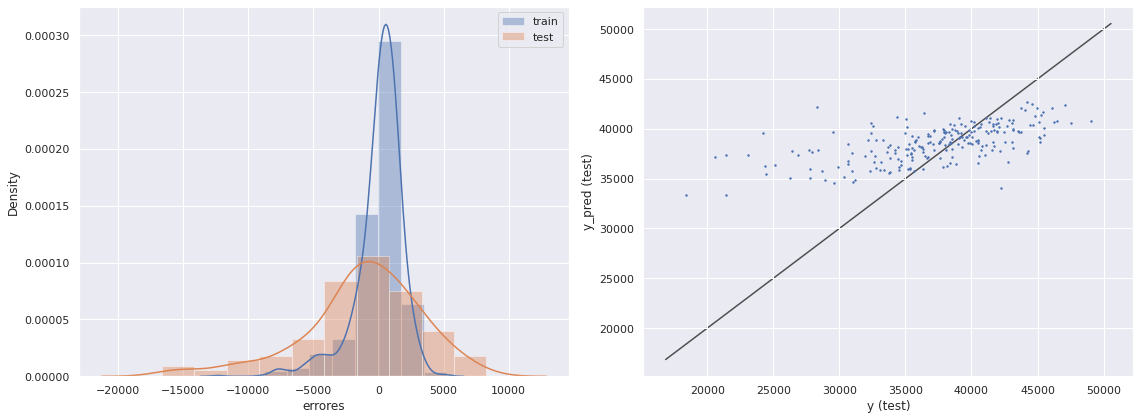

In [91]:
# Evaluación del modelo
modelos = ['Radmon Forest']
modelos_obj = [rf]

evaluar_modelos(modelos, modelos_obj, X_train, X_test, y_train, y_test)

Hay mucha varianza en la densidad de errores. Además, para valores bajos de Y el modelo sobre-estima (incluso casi hasta el doble) y para valores altos de Y, el modelo sub-estima.

Adicionalmente, se observa que las predicciones (y_pred) están acotadas entre 34000 y 43000, el modelo no generaliza bien pues no la relación entre Y_pred e Y no sigue la función identidad.

#### Optimización de hiperparámetros para RandomForest

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [92]:
from sklearn.model_selection import RandomizedSearchCV

**>>** Para hacer el cross validation para series de tiempo se utiliza TimeSeriesSplit

In [93]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 4)

In [94]:
# Grilla para Ramdom Search
param_grid_rf = {'n_estimators': [100, 150, 200, 250],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [5, 10, 20, 30],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]
                }

**>>** Estimador

In [95]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf

RandomForestRegressor(n_jobs=-1, random_state=42)

In [96]:
#  Random Search
rf = RandomizedSearchCV(estimator = rf, param_distributions = param_grid_rf, n_iter = 100, 
                        cv = tscv, verbose=0, random_state=42, n_jobs = -1)

# Entrenamos: XGBoost con la grilla definida arriba y CV con tamaño de Fold=5
rf.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 150, 200, 250]},
                   random_state=42)

In [97]:
print("Mejores parametros: "+str(rf.best_params_))
print("Mejor Score: "+str(rf.best_score_)+'\n')

Mejores parametros: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
Mejor Score: 0.37332511766310383



> Se entrena un nuevo modelo con los mejores hiperparámetros

In [98]:
rf_final = RandomForestRegressor(n_estimators=200, min_samples_split= 5, 
                                 min_samples_leaf=2, max_features = 'auto', max_depth = 10, bootstrap=True,
                                 random_state=42, n_jobs=-1)

In [99]:
rf_final.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=200, n_jobs=-1, random_state=42)

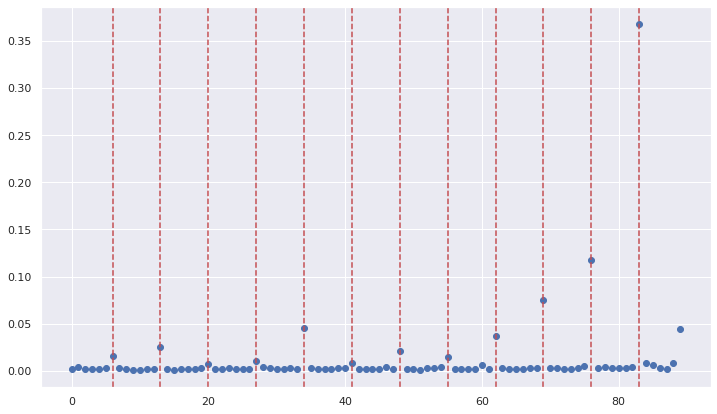

In [100]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf_final.feature_importances_.size),rf_final.feature_importances_)
for x in np.arange(start=6, stop=int(look_back), step=7): #np.arange(3)*52:
    plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

In [101]:
y_pred = rf_final.predict(X)
y_train_pred = rf_final.predict(X_train)
y_test_pred = rf_final.predict(X_test)

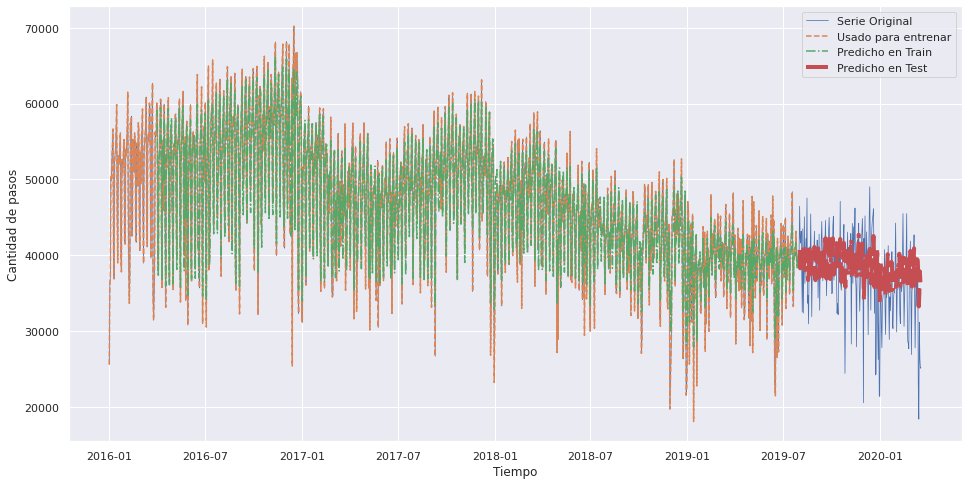

In [102]:
plt.figure(figsize=(16,8))
offset = -1
plt.plot(diario_illia_final.index[:length_total], diario_illia_final[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario_illia_final.index[:N_train + look_back], diario_illia_final[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario_illia_final.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario_illia_final.index[N_train+look_back: length_total + offset], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

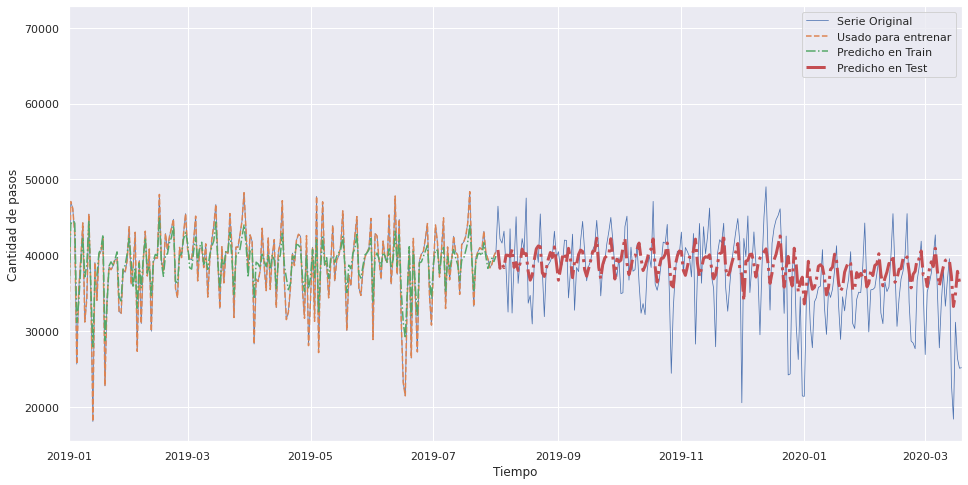

In [103]:
plt.figure(figsize=(16,8))
plt.plot(diario_illia_final.index[:length_total], diario_illia_final[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario_illia_final.index[:N_train + look_back], diario_illia_final[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario_illia_final.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario_illia_final.index[N_train+look_back: length_total+ offset], y_test_pred,'-.', lw = 3, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.xlim(datetime.date(2019,1,1), datetime.date(2020,3,19))
plt.show()

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Modelo: Radmon Forest - Hiperparámetros optimizados
Raíz del error cuadrático medio en Train: 2476.9231260911724
Raíz del error cuadrático medio en Test: 4766.939676352962


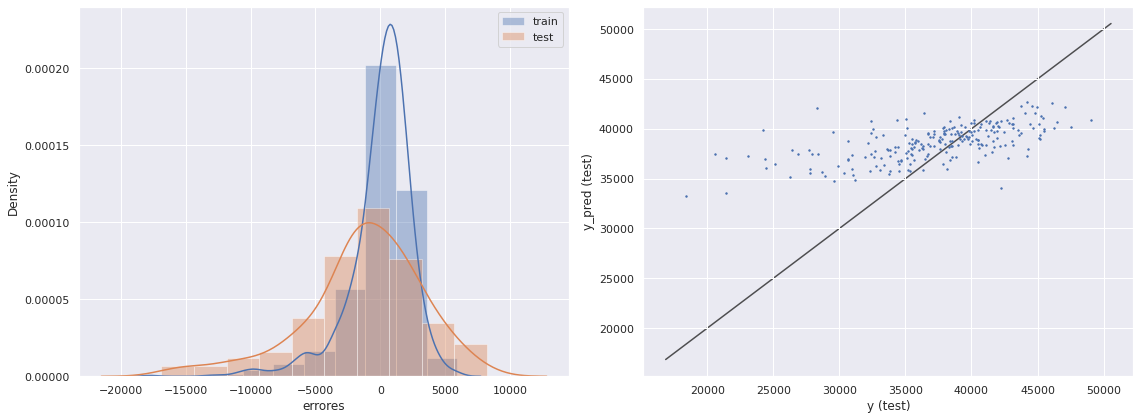

In [104]:
# Evaluación del modelo
modelos = ['Radmon Forest - Hiperparámetros optimizados']
modelos_obj = [rf_final]

evaluar_modelos(modelos, modelos_obj, X_train, X_test, y_train, y_test)

La raíz cuadrada del cuadrático medio mejora y la densidad de errores también mejora en su varianza, pero es muy leve.

Se sigue viendo que el modelo no generaliza bien, las predicciones siguen acotadas y sobreestima con mucho error para valores bajos.


#### Comparación entre los modelos

### Segundo modelo XGBoost

In [105]:
# Se importa la librería
import xgboost as xgb

Se realiza un modelo con alunos hiperparámetros por defecto del modelo

In [106]:
#model_xg = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree',
#                            n_estimators=100, max_depth=10, learning_rate=0.1, 
#                            subsample = 0.7, colsample_bytree=0.8, random_state=42, n_jobs=-1)

In [107]:
model_xg = xgb.XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1)

In [108]:
model_xg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

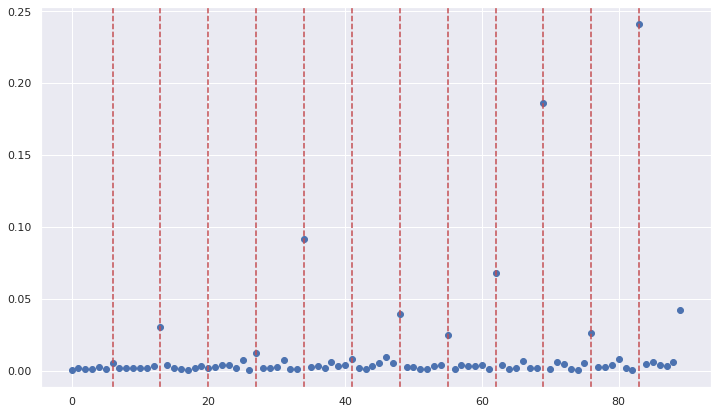

In [109]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(model_xg.feature_importances_.size), model_xg.feature_importances_)
for x in np.arange(start=6, stop=int(look_back), step=7): #np.arange(3)*52:
    plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

Tal como se veía en las gráficas de autocorrelación, los features de importancia son los días de la semana anterior y el mismo día de las tres/cuatro semanas anteriores, incluso la semana 5 a 8.

In [110]:
y_pred = model_xg.predict(X)
y_train_pred = model_xg.predict(X_train)
y_test_pred = model_xg.predict(X_test)

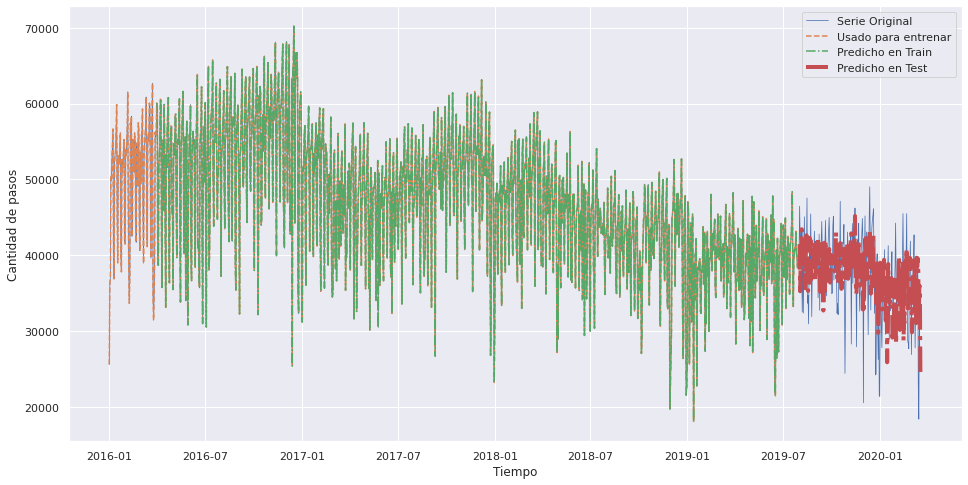

In [111]:
plt.figure(figsize=(16,8))
offset = -1
plt.plot(diario_illia_final.index[:length_total], diario_illia_final[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario_illia_final.index[:N_train + look_back], diario_illia_final[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario_illia_final.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario_illia_final.index[N_train+look_back: length_total + offset], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

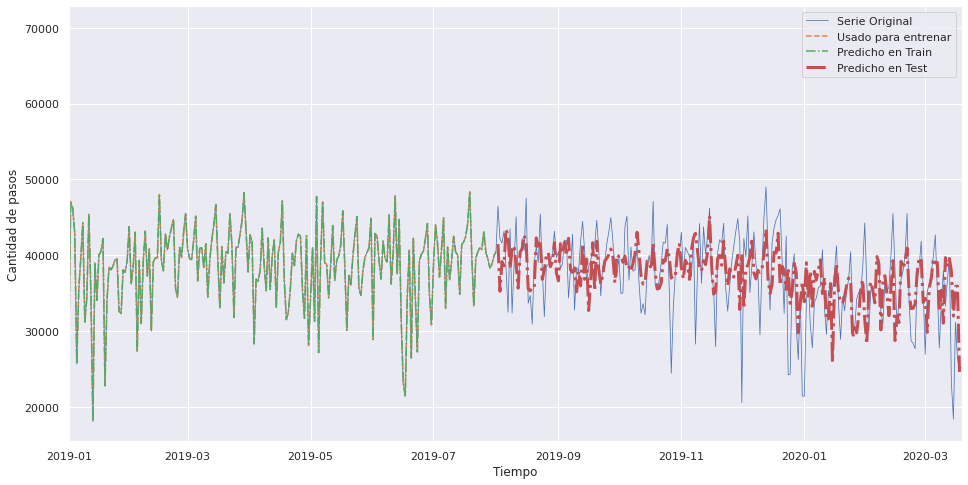

In [112]:
plt.figure(figsize=(16,8))
plt.plot(diario_illia_final.index[:length_total], diario_illia_final[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario_illia_final.index[:N_train + look_back], diario_illia_final[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario_illia_final.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario_illia_final.index[N_train+look_back: length_total+ offset], y_test_pred,'-.', lw = 3, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.xlim(datetime.date(2019,1,1), datetime.date(2020,3,19))
plt.show()

<class 'xgboost.sklearn.XGBRegressor'>
Modelo: Modelo Avanzado - XGBoost
Raíz del error cuadrático medio en Train: 0.6539692553996966
Raíz del error cuadrático medio en Test: 4830.876515317584


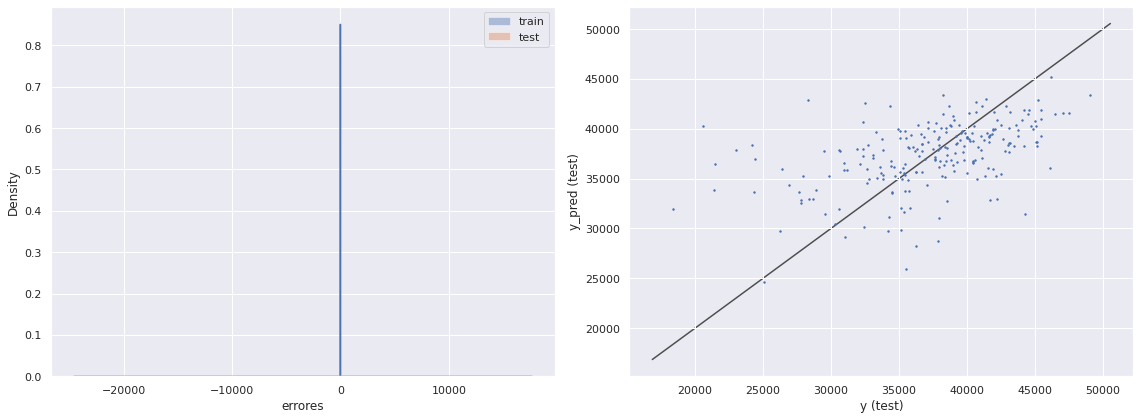

In [113]:
# Evaluación del modelo
modelos = ['Modelo Avanzado - XGBoost']
modelos_obj = [model_xg]

evaluar_modelos(modelos, modelos_obj, X_train, X_test, y_train, y_test)

El modelo mejora mucho incluso contra el Random Forest con parámetros optimizados.

Y e Y_pred de test se aproximan más al a curva f(x) = x, lo cual se evidencia en que el RSME mejora también

#### Comparación entre los modelos

#### Optimización de hiperparámetros

In [114]:
# Grilla para Ramdom Search
param_grid_xg = {'n_estimators': [100, 150, 200, 250],
              'max_depth': np.array([5, 10, 20, 30]),
              'learning_rate': [0.01, 0.1, 0.3, 0.5], 
              'subsample': [0.4, 0.7, 1.0],
              'colsample_bytree': [0.2, 0.4, 0.8, 1.0],
              'alpha':[6, 10, 12],
              'booster':['gbtree','gblinear'],
              'objective':['reg:linear','reg:squarederror']   
             }

In [115]:
model_xg = xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)   # booster='gbtree'    seed = 42

model_xg

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=0)

In [116]:
#pd.DataFrame(X_train).info()

In [117]:
#  Random Search
model_xg = RandomizedSearchCV(model_xg, param_grid_xg, n_iter=100, random_state=42, cv=tscv)

# Entrenamos: XGBoost con la grilla definida arriba y CV con tamaño de Fold=5
model_xg.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_w...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=0),
                   n_iter=100,
                   param_distributions={'alpha': [6, 10, 12]

In [118]:
print("Mejores parametros: "+str(model_xg.best_params_))
print("Mejor Score: "+str(model_xg.best_score_)+'\n')

Mejores parametros: {'subsample': 0.4, 'objective': 'reg:squarederror', 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.2, 'booster': 'gblinear', 'alpha': 12}
Mejor Score: 0.32063823699265365



In [119]:
model_xg_final = xgb.XGBRegressor(subsample = 0.4, objective='reg:squarederror', n_estimators=200,
                 max_depth=10, learning_rate=0.1, colsample_bytree=0.2, booster='gblinear', alpha=12,  #booster='gbtree'
                 random_state=42, n_jobs=-1)

In [120]:
model_xg_final.fit(X_train, y_train)

XGBRegressor(alpha=12, base_score=0.5, booster='gblinear',
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.2, gamma=None, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=10,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=0.4, tree_method=None, validate_parameters=1,
             verbosity=None)

In [121]:
if (model_xg_final.booster == 'gbtree'):
    plt.figure(figsize = (12,7))
    plt.scatter(np.arange(model_xg_final.feature_importances_.size), model_xg_final.feature_importances_)
    for x in np.arange(start=6, stop=int(look_back), step=7): #np.arange(3)*52:
        plt.axvline(x, linestyle ='--', color= 'r')
    plt.show()

In [122]:
y_pred = model_xg_final.predict(X)
y_train_pred = model_xg_final.predict(X_train)
y_test_pred = model_xg_final.predict(X_test)

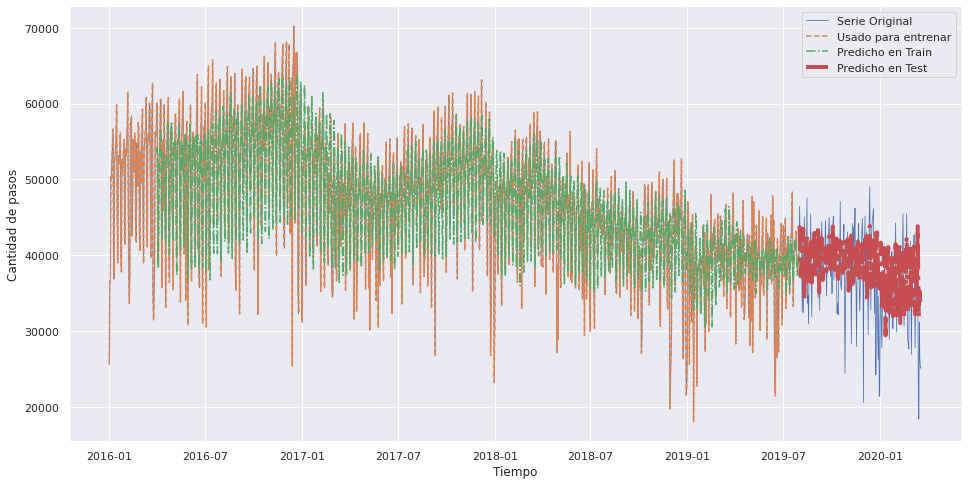

In [123]:
plt.figure(figsize=(16,8))
offset = -1
plt.plot(diario_illia_final.index[:length_total], diario_illia_final[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario_illia_final.index[:N_train + look_back], diario_illia_final[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario_illia_final.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario_illia_final.index[N_train+look_back: length_total + offset], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

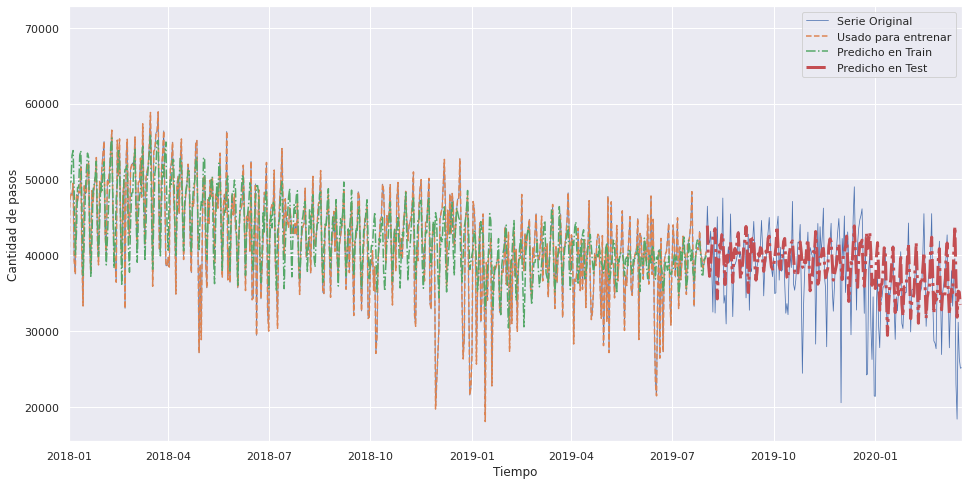

In [124]:
plt.figure(figsize=(16,8))
plt.plot(diario_illia_final.index[:length_total], diario_illia_final[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario_illia_final.index[:N_train + look_back], diario_illia_final[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario_illia_final.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario_illia_final.index[N_train+look_back: length_total+ offset], y_test_pred,'-.', lw = 3, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.xlim(datetime.date(2018,1,1), datetime.date(2020,3,19))
plt.show()

<class 'xgboost.sklearn.XGBRegressor'>
Modelo: Modelo Avanzado - XGBoost Optimizado
Raíz del error cuadrático medio en Train: 5100.965425839533
Raíz del error cuadrático medio en Test: 4710.828202410077


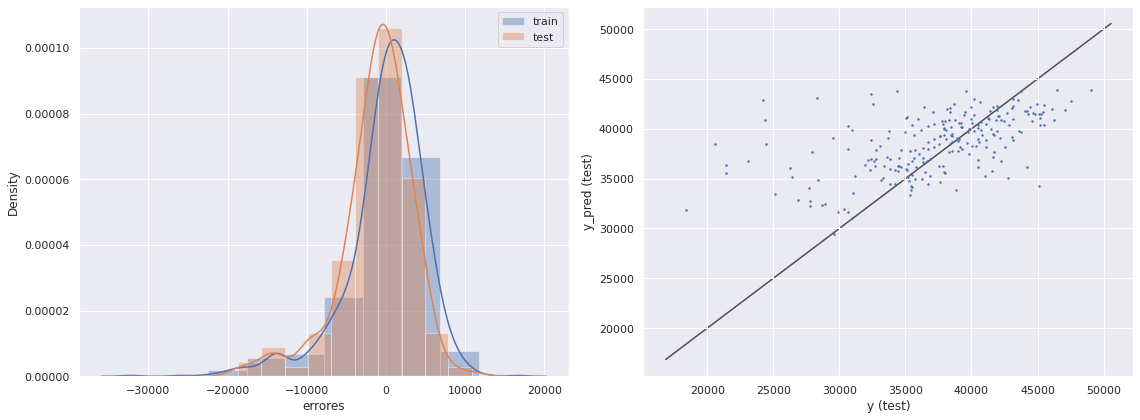

In [125]:
# Evaluación del modelo
modelos = ['Modelo Avanzado - XGBoost Optimizado']
modelos_obj = [model_xg_final]

evaluar_modelos(modelos, modelos_obj, X_train, X_test, y_train, y_test )

#### Comparación entre los modelos

## 5. Agrandando el dataset añadiendo años 2015 a 2010

Lectura de los años 2015 a 2010. Dichos años no contienen las columnas 'hora_inicio', 'hora_fin', solo contiene la columna 'hora'. Tampoco contiene la columna 'sentido'

> Se calcula la hora_fin sumando 1 a la hora
> Se crea la columna sentido con el dato 'no data'

Además, los años 2014 y 2010 tienen NAN, se proced eliminar dichos valores

In [126]:
columns = ['periodo','fecha','hora','dia','estacion','tipo_vehiculo','forma_pago','cantidad_pasos']

col_dtypes= {'periodo': np.int16, 'hora': np.int8, 'cantidad_pasos': np.int32}

data_2015 = pd.read_csv('datasets/proyecto3_ST/flujo-vehicular-2015.csv', sep =',', usecols=columns)[columns]
data_2015 = data_2015.astype(col_dtypes)

data_2014 = pd.read_csv('datasets/proyecto3_ST/flujo-vehicular-2014.csv', sep =',', usecols=columns)[columns]
data_2014.dropna(inplace=True)     ## 2014 tiene algunas filas con valores faltantes
data_2014 = data_2014.astype(col_dtypes)

data_2013 = pd.read_csv('datasets/proyecto3_ST/flujo-vehicular-2013.csv', sep =',', usecols=columns)[columns]
data_2013 = data_2013.astype(col_dtypes)

data_2012 = pd.read_csv('datasets/proyecto3_ST/flujo-vehicular-2012.csv', sep =',', usecols=columns)[columns]
data_2012 = data_2012.astype(col_dtypes)

data_2011 = pd.read_csv('datasets/proyecto3_ST/flujo-vehicular-2011.csv', sep =',', usecols=columns)[columns]
data_2011 = data_2011.astype(col_dtypes)

data_2010 = pd.read_csv('datasets/proyecto3_ST/flujo-vehicular-2010.csv', sep =',', usecols=columns)[columns]
data_2010.dropna(inplace=True)
data_2010 = data_2010.astype(col_dtypes)

In [127]:
columns = ['periodo', 'fecha', 'hora_inicio', 'hora_fin', 'dia', 'estacion', 
           'sentido', 'tipo_vehiculo', 'forma_pago', 'cantidad_pasos']

for df in [data_2015, data_2014, data_2013, data_2012, data_2011, data_2010]:
    # Se crea columna de sentido con el valor 'no data'
    df['sentido'] = 'no data'
    df['hora_fin'] = df['hora'].map(lambda value: (value + 1) if value <= 22 else 0 )
    df.rename(columns = {'hora':'hora_inicio'}, inplace = True) 
    df = df[columns]
    
# Se reordenan las columnas para cada dataset
data_2015 = data_2015[columns]
data_2014 = data_2014[columns]
data_2013 = data_2013[columns]
data_2012 = data_2012[columns]
data_2011 = data_2011[columns]
data_2010 = data_2010[columns]

Se comvierte a minusculas y se la fecha a datetime

In [128]:
for df in [data_2020, data_2019, data_2018, data_2017, data_2016,
          data_2015, data_2014, data_2013, data_2012, data_2011, data_2010]:
    #df['cantidad_pasos'] = df['cantidad_pasos'].astype(np.int64)   # Se convierte la cantidad de pasos a int32
    df['fecha'] = pd.to_datetime(df['fecha'])
    for col in ['dia', 'estacion', 'sentido', 'tipo_vehiculo', 'forma_pago']:
        df[col] = df[col].str.lower()

>Para la columna 'forma_pago' de 2010 a 2016, el valor 'aupass' se convierte a 'telepase'.

In [129]:
for df in [data_2016, data_2015, data_2014, data_2013, data_2012, data_2011, data_2010]:
    df['forma_pago'] = df['forma_pago'].map(lambda value: 'telepase' if value == 'aupass' else value )

Filtrado del datset: estación Lillia y pago Efectivo

In [130]:
#Unimos los datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset_illia = pd.concat([data_2020[(data_2020['fecha'] >= "2020-01-01") & (data_2020['fecha'] <= "2020-03-19")],
                    data_2019, data_2018, data_2017, data_2016,
                    data_2015, data_2014, data_2013, data_2012, data_2011, data_2010])

#dataset_illia_total = dataset_illia.copy()

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo, Telepase
mask = np.logical_and(dataset_illia.estacion=='illia', dataset_illia.forma_pago.isin(['efectivo'])) #, 'telepase']))
dataset_illia = dataset_illia[mask]

#Quitamos las columnas que no vamos a utilizar
dataset_illia.drop(columns = ['periodo','hora_inicio','estacion', 'forma_pago'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset_illia['fecha2'] = pd.to_datetime(dataset_illia.fecha) + pd.to_timedelta(dataset_illia.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset_illia.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset_illia.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
dataset_illia.sort_values('fecha', inplace = True)
dataset_illia.reset_index(drop=True, inplace = True)
print("Tamaño del dataset por hora: " + str(dataset_illia.shape))

#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario_illia = dataset_illia.resample('D', on = 'fecha').sum()
print("Tamaño del dataset por día: " + str(diario_illia.shape))
diario_illia.head()

Tamaño del dataset por hora: (722498, 5)
Tamaño del dataset por día: (3731, 1)


cantidad_pasos
fecha                     
2010-01-01           21123
2010-01-02           31115
2010-01-03           34024
2010-01-04           51844
2010-01-05           54809

Manejo de Outliers

In [131]:
limite_inferior = 20000
print("Cantidad de pasos por debajo de 20 mil: " + str(diario_illia[diario_illia["cantidad_pasos"] < limite_inferior].value_counts().sum()))

diario_illia[diario_illia["cantidad_pasos"] < limite_inferior]

Cantidad de pasos por debajo de 20 mil: 29


cantidad_pasos
fecha                     
2010-05-13               0
2010-12-04               0
2010-12-05               0
2010-12-06               0
2010-12-07             670
2010-12-10            6137
2011-01-01           17970
2013-03-28               0
2013-03-29               0
2013-03-30               0
2013-03-31           19052
2013-11-20           16620
2013-12-30           14485
2013-12-31            5191
2014-01-01            7979
2014-01-02           18024
2014-01-04               1
2014-01-05               1
2014-01-06               1
2014-04-10           16160
2017-04-06              40
2018-06-25               0
2018-09-25               0
2018-11-29           19728
2018-11-30               0
2018-12-01             350
2019-01-13           18076
2019-05-29               0
2020-03-15           18390

In [132]:
diario_illia.cantidad_pasos[diario_illia.cantidad_pasos < limite_inferior] = np.nan

In [133]:
diario_illia = diario_illia.interpolate()

# Tipo de dato entero acorde con el rango de cada variable
col_dtypes= {'cantidad_pasos': np.int32}
diario_illia = diario_illia.astype(col_dtypes)

In [134]:
ventana = 30*2*2 #int(365*2/7)
diario_promedio_tendencia = diario_illia.cantidad_pasos.rolling(window=ventana, center = True).mean()
diario_promedio_tendencia

fecha
2010-01-01   NaN
2010-01-02   NaN
2010-01-03   NaN
2010-01-04   NaN
2010-01-05   NaN
              ..
2020-03-15   NaN
2020-03-16   NaN
2020-03-17   NaN
2020-03-18   NaN
2020-03-19   NaN
Freq: D, Name: cantidad_pasos, Length: 3731, dtype: float64

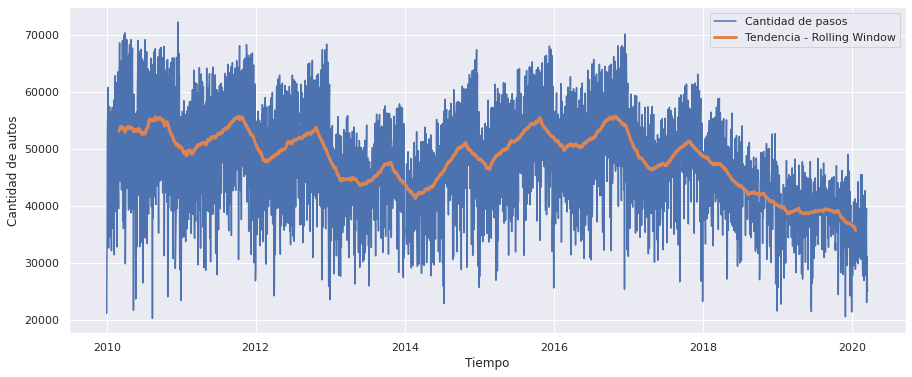

In [135]:
plt.figure(figsize = (15,6))
plt.plot(diario_illia.index, diario_illia.cantidad_pasos, label = 'Cantidad de pasos')
plt.plot(diario_promedio_tendencia, lw = 3, label = 'Tendencia - Rolling Window')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
#plt.xlim(datetime.date(2018,1,1), datetime.date(2018,10,1))
plt.show()

#### Predicción a Futuro - One Step, ahora se define 6 meses para predecir

In [136]:
## Dataset para la prediccón
diario_illia_final = diario_illia.cantidad_pasos.copy()

## 6 meses para predecir
look_back = 30*6 

# Conjunto X y y
N = diario_illia_final.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape, N)

for i in range(X.shape[0]):
    X[i,:] = diario_illia_final.iloc[i:i+look_back]
    y[i] = diario_illia_final.iloc[i+look_back]


N_train = int(diario_illia_final.shape[0]*0.90 - look_back) # cantidad de instancias que vamos a usar para entrenar. 
N_test = int(diario_illia_final.shape[0]*0.10) #cantidad de puntos que vamos a usar para evaluar

N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
#print(X_train.shape, y_train.shape)
print("Tamaño conjunto X_train: " + str(X_train.shape), ". Tamaño conjunto y_train: " + str(y_train.shape))

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print("Tamaño conjunto X_test: " + str(X_test.shape), ". Tamaño conjunto y_test: " + str(y_test.shape))

(3550, 180) (3550,) 3731
Tamaño conjunto X_train: (3177, 180) . Tamaño conjunto y_train: (3177,)
Tamaño conjunto X_test: (373, 180) . Tamaño conjunto y_test: (373,)


#### Modelo Random Forest

In [137]:
## Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs = -1)
rf.fit(X_train,y_train)

y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

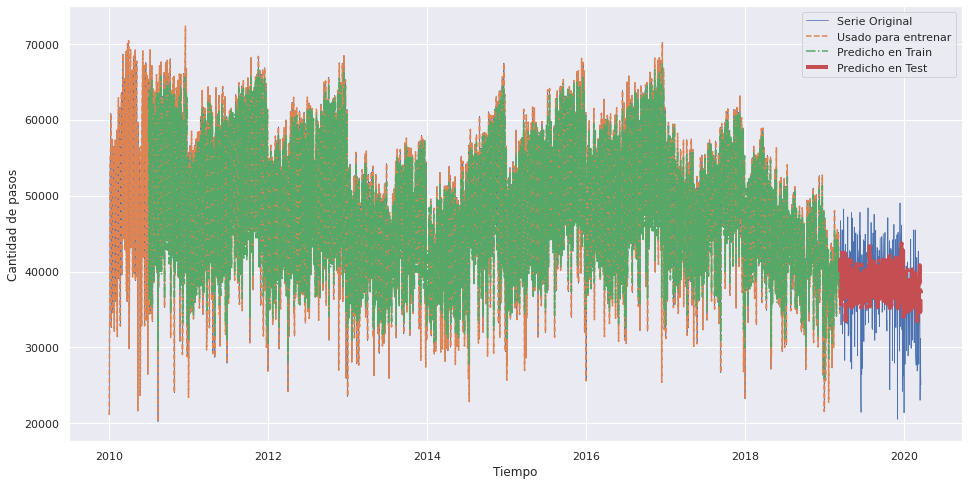

In [138]:
plt.figure(figsize=(16,8))
offset = 0
plt.plot(diario_illia_final.index[:length_total], diario_illia_final[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario_illia_final.index[:N_train + look_back], diario_illia_final[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario_illia_final.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario_illia_final.index[N_train+look_back: length_total + offset], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

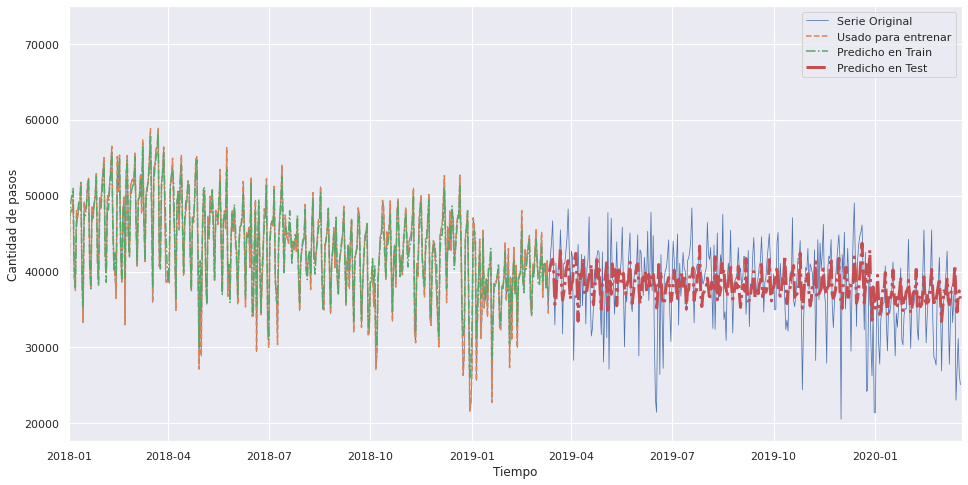

In [139]:
plt.figure(figsize=(16,8))
plt.plot(diario_illia_final.index[:length_total], diario_illia_final[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario_illia_final.index[:N_train + look_back], diario_illia_final[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario_illia_final.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario_illia_final.index[N_train+look_back: length_total+ offset], y_test_pred,'-.', lw = 3, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.xlim(datetime.date(2018,1,1), datetime.date(2020,3,19))
plt.show()

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Modelo: Radmon Forest
Raíz del error cuadrático medio en Train: 2047.062321244541
Raíz del error cuadrático medio en Test: 4784.721943844949


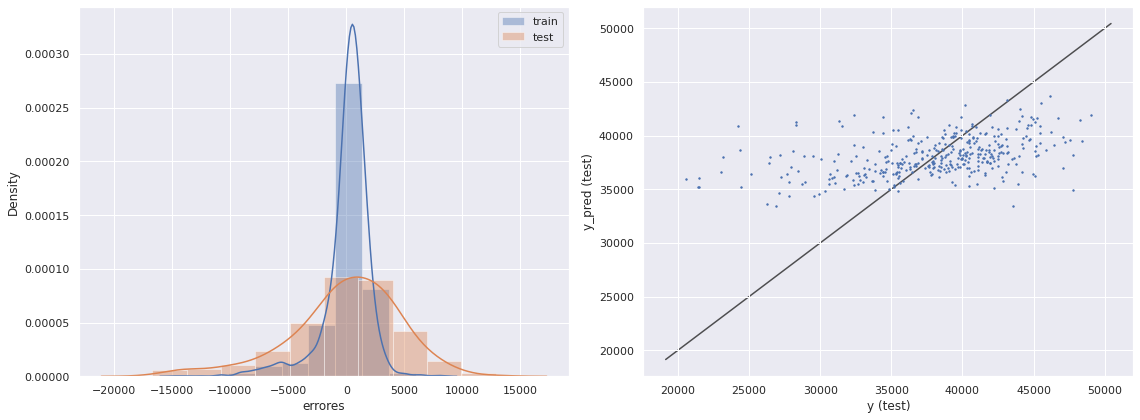

In [140]:
# Evaluación del modelo
modelos = ['Radmon Forest']
modelos_obj = [rf]

evaluar_modelos(modelos, modelos_obj, X_train, X_test, y_train, y_test)

#### Comparación entre los modelos

#### Modelo XGBoost

In [141]:
## XGBoost
model_xg = xgb.XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1)
model_xg.fit(X_train, y_train)

y_pred = model_xg.predict(X)
y_train_pred = model_xg.predict(X_train)
y_test_pred = model_xg.predict(X_test)

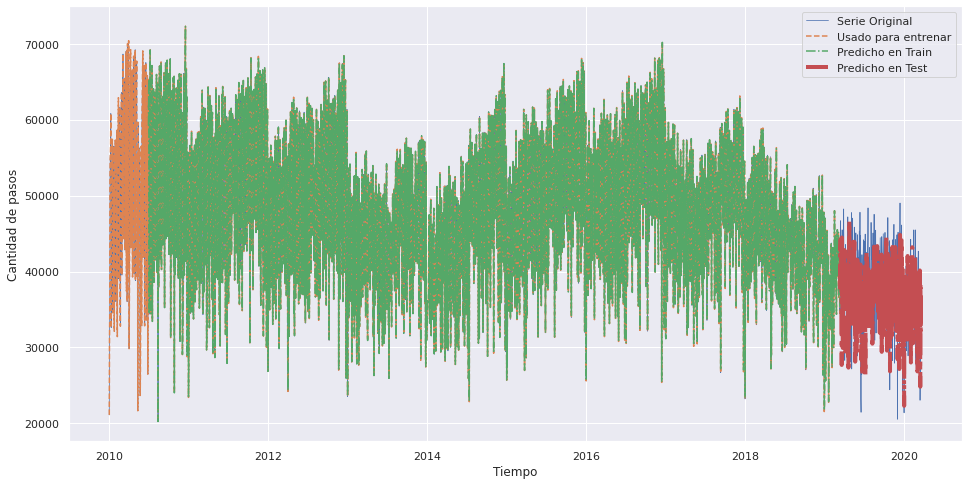

In [142]:
plt.figure(figsize=(16,8))
offset = 0 #-1
plt.plot(diario_illia_final.index[:length_total], diario_illia_final[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario_illia_final.index[:N_train + look_back], diario_illia_final[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario_illia_final.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario_illia_final.index[N_train+look_back: length_total + offset], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

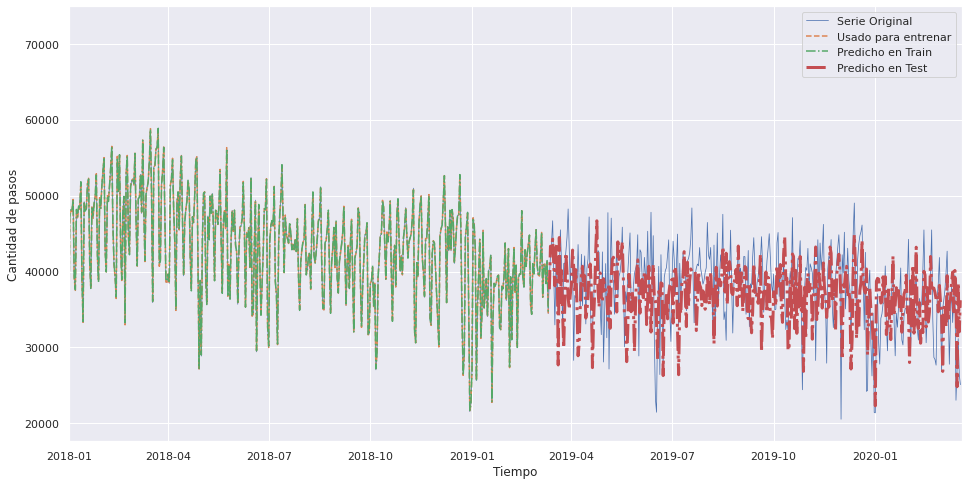

In [143]:
plt.figure(figsize=(16,8))
plt.plot(diario_illia_final.index[:length_total], diario_illia_final[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario_illia_final.index[:N_train + look_back], diario_illia_final[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario_illia_final.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario_illia_final.index[N_train+look_back: length_total+ offset], y_test_pred,'-.', lw = 3, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.xlim(datetime.date(2018,1,1), datetime.date(2020,3,19))
plt.show()

<class 'xgboost.sklearn.XGBRegressor'>
Modelo: Modelo Avanzado - XGBoost
Raíz del error cuadrático medio en Train: 77.67778319393278
Raíz del error cuadrático medio en Test: 5583.933562479137


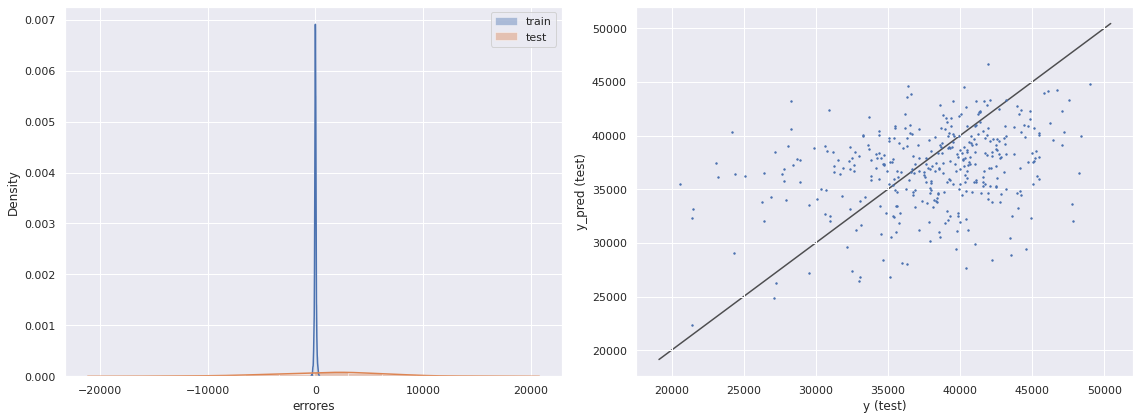

In [144]:
# Evaluación del modelo
modelos = ['Modelo Avanzado - XGBoost']
modelos_obj = [model_xg]

evaluar_modelos(modelos, modelos_obj, X_train, X_test, y_train, y_test)

#### Comparación entre los modelos

#### Optimización de hiperparámetros

In [145]:
#assert False, "breakpoint"

##### Random Forest

In [146]:
tscv = TimeSeriesSplit(n_splits = 4)

In [147]:
# Grilla para Ramdom Search
param_grid_rf = {'n_estimators': [100, 150, 200, 250],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [5, 10, 20, 30],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]
                }


rf = RandomForestRegressor(random_state=42, n_jobs=-1)

#  Random Search
rf = RandomizedSearchCV(estimator = rf, param_distributions = param_grid_rf, n_iter = 100, 
                        cv = tscv, verbose=0, random_state=42, n_jobs = -1)

# Entrenamos: XGBoost con la grilla definida arriba y CV con tamaño de Fold=5
rf.fit(X_train, y_train)

print("Mejores parametros: "+str(rf.best_params_))
print("Mejor Score: "+str(rf.best_score_)+'\n')

y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

Mejores parametros: {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}
Mejor Score: 0.6027360460245024



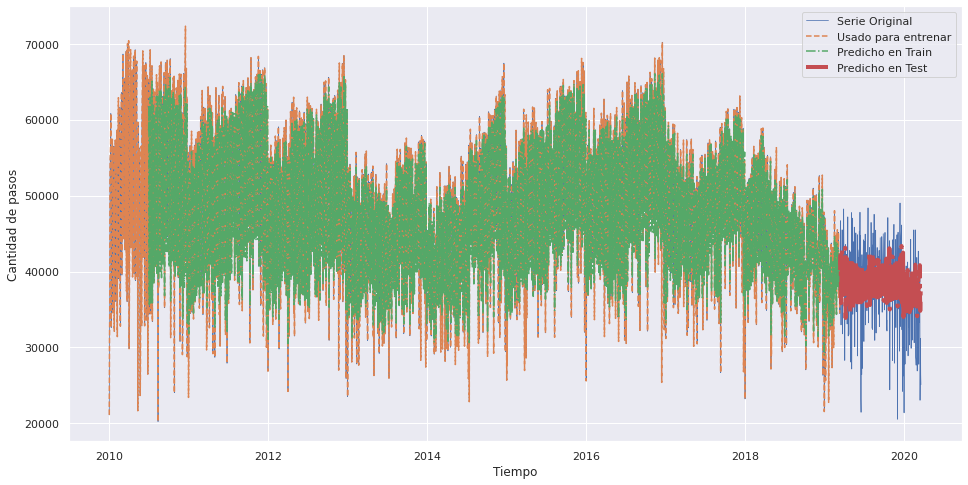

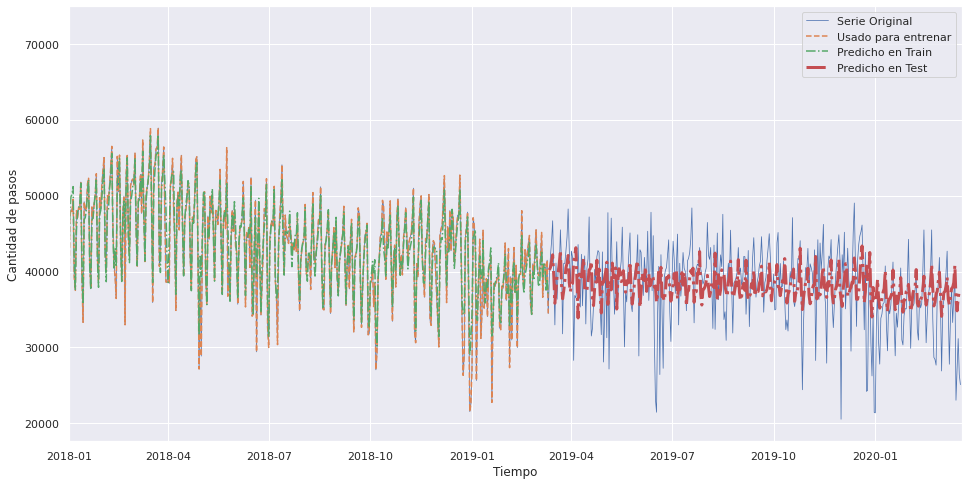

<class 'sklearn.model_selection._search.RandomizedSearchCV'>
Modelo: Radmon Forest - Hiperparámetros optimizados
Raíz del error cuadrático medio en Train: 2921.952745568267
Raíz del error cuadrático medio en Test: 4802.192803866167


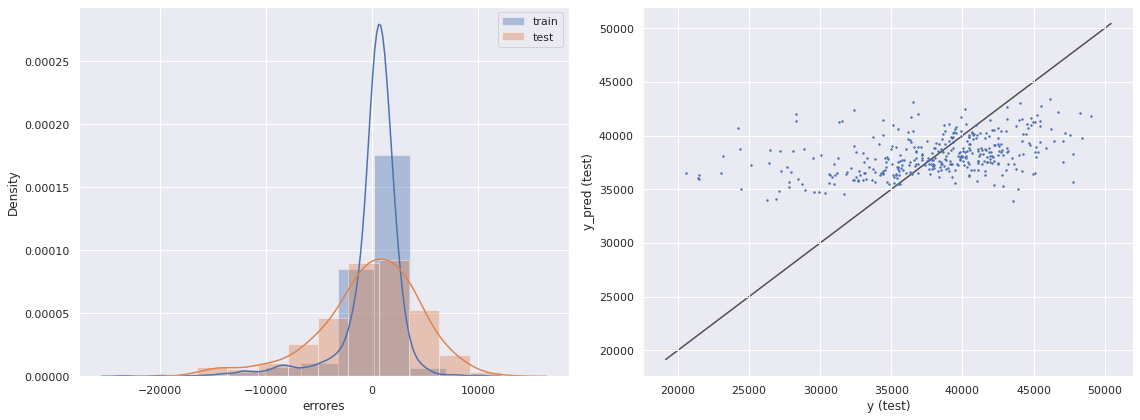

In [148]:
plt.figure(figsize=(16,8))
offset = 0 #-1
plt.plot(diario_illia_final.index[:length_total], diario_illia_final[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario_illia_final.index[:N_train + look_back], diario_illia_final[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario_illia_final.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario_illia_final.index[N_train+look_back: length_total + offset], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()



plt.figure(figsize=(16,8))
plt.plot(diario_illia_final.index[:length_total], diario_illia_final[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario_illia_final.index[:N_train + look_back], diario_illia_final[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario_illia_final.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario_illia_final.index[N_train+look_back: length_total+ offset], y_test_pred,'-.', lw = 3, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.xlim(datetime.date(2018,1,1), datetime.date(2020,3,19))
plt.show()


# Evaluación del modelo
modelos = ['Radmon Forest - Hiperparámetros optimizados']
modelos_obj = [rf]

evaluar_modelos(modelos, modelos_obj, X_train, X_test, y_train, y_test)

#### Comparación entre los modelos

##### XGBoost

In [149]:
# Grilla para Ramdom Search
param_grid_xg = {'n_estimators': [100, 150, 200, 250],
              'max_depth': np.array([5, 10, 20, 30]),
              'learning_rate': [0.01, 0.1, 0.3, 0.5], 
              'subsample': [0.4, 0.7, 1.0],
              'colsample_bytree': [0.2, 0.4, 0.8, 1.0],
              'alpha':[6, 10, 12],
              'booster':['gbtree','gblinear'],
              'objective':['reg:linear','reg:squarederror']   
             }

model_xg = xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)   # booster='gbtree'    seed = 42

model_xg


#  Random Search
model_xg = RandomizedSearchCV(model_xg, param_grid_xg, n_iter=100, random_state=42, cv=tscv)

# Entrenamos: XGBoost con la grilla definida arriba y CV con tamaño de Fold=5
model_xg.fit(X_train, y_train)

print("Mejores parametros: "+str(model_xg.best_params_))
print("Mejor Score: "+str(model_xg.best_score_)+'\n')

y_pred = model_xg.predict(X)
y_train_pred = model_xg.predict(X_train)
y_test_pred = model_xg.predict(X_test)

Mejores parametros: {'subsample': 0.7, 'objective': 'reg:squarederror', 'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.4, 'booster': 'gbtree', 'alpha': 12}
Mejor Score: 0.5813118816023146



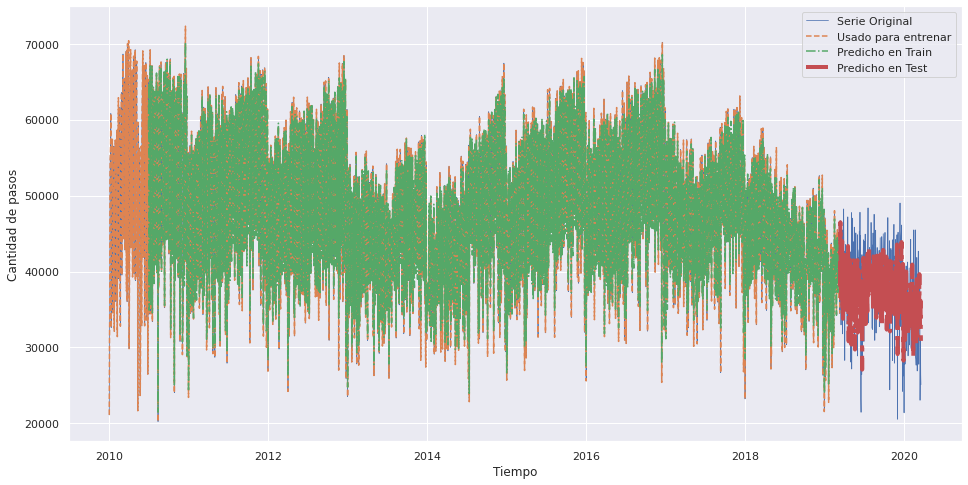

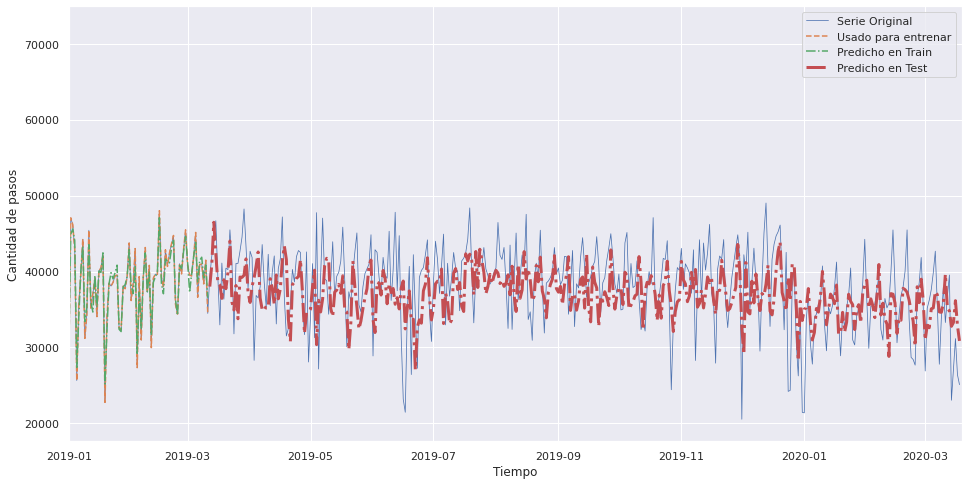

<class 'sklearn.model_selection._search.RandomizedSearchCV'>
Modelo: Modelo Avanzado - XGBoost Optimizado
Raíz del error cuadrático medio en Train: 1423.5686405725444
Raíz del error cuadrático medio en Test: 4908.159212944546


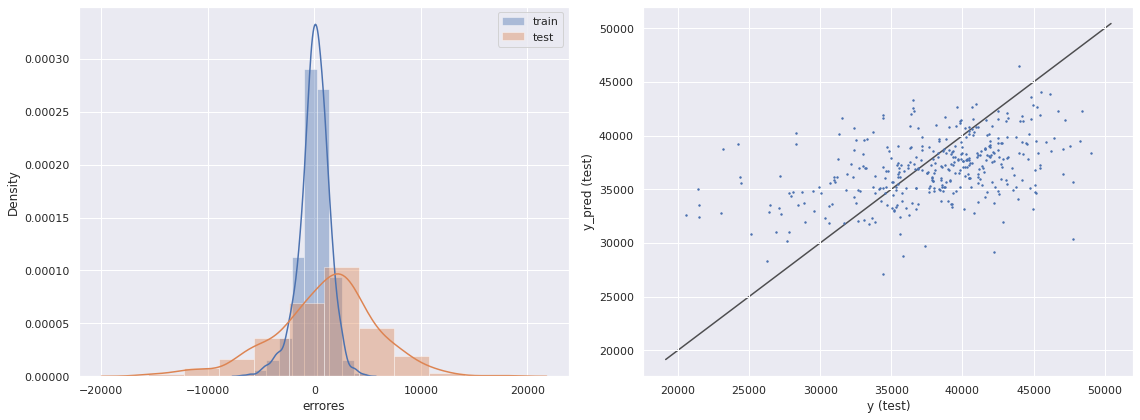

In [150]:
plt.figure(figsize=(16,8))
offset = 0 #-1
plt.plot(diario_illia_final.index[:length_total], diario_illia_final[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario_illia_final.index[:N_train + look_back], diario_illia_final[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario_illia_final.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario_illia_final.index[N_train+look_back: length_total + offset], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()


plt.figure(figsize=(16,8))
plt.plot(diario_illia_final.index[:length_total], diario_illia_final[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario_illia_final.index[:N_train + look_back], diario_illia_final[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario_illia_final.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario_illia_final.index[N_train+look_back: length_total+ offset], y_test_pred,'-.', lw = 3, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.xlim(datetime.date(2019,1,1), datetime.date(2020,3,19))
plt.show()

# Evaluación del modelo
modelos = ['Modelo Avanzado - XGBoost Optimizado']
modelos_obj = [model_xg]

evaluar_modelos(modelos, modelos_obj, X_train, X_test, y_train, y_test )

#### Comparación entre los modelos

## 6. Conclusiones y metodología utilizada

En general para todos los modelos, las predicciones para valores bajos de Y no son precisas, son sobre-estimadas.
Los modelos de Random Forest tienden a acotar Y_pred así sea que se realice la optimización de hiperparámetros.

Los modelos de XGBoost tienen un mejor desempeño sobre los de Random Forest, tienen un costo computacional menor, ya que convergen en menor tiempo y emplean menos recursos (RAM y CPU).

Agregar más años (2010 a 2021) y aumentar el nro de meses para precedecir (de 3 meses a 6), permite obtener mejores resultados, sobretodo menor varianza en la densidad de errores, mejores predicciones para valores bajos de Y y que la nube de relación entre Y e Y_pred se acerque más a la función identidad (Y e Y_pred siguen mejor línea y=x).
Adicionalmente, el modelo mejora en su predicción sin necesidad de realizar la optimización de los hiperparámetros; esto es, al realzar el Random Search para los modelos, en general no se obtiene un mejor rendimiento significativo, solo con el parámetro n_estimators=200 el XGBoost tiene un buen rendimiento, es muy costoso tratar de optimizarlos para obtener mejoras leves.


- ¿Qué se podría mejorar?

Realizar la imputación de valores faltanes para la Cantidad de pasos realizando un promedio movil por ventana en lugar de una interpolación.

Tener en cuenta las variables categóricas (Sentido, Forma pago, Estación) como features para el modelo (con su correspondiente procesamiento label encoder)

Utilizar otra métrica para la evalaución del modelo, ejemplo R2.

Revisar la docuemntación de los modelos para agregar más hiperparámetros al Random Search.

